In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import pickle
import math
import plotly
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
# import the relevant Keras modules
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
# Check if GPU computation is available.
class ActivateGPU(object):
    def __init__(self):
        self.is_available = bool(tf.config.list_physical_devices("GPU"))
        self.physical_device = tf.config.experimental.list_physical_devices("GPU")
        
    def check_device(self):
        print("Physical Devices:")
        for device in tf.config.list_physical_devices():
            print(device)

    def set_gpu(self):
        if self.is_available:
            print(f"GPU availability: {self.is_available}")
        try:
            tf.config.experimental.set_memory_growth(self.physical_device[0], True)
            print("Num GPUs: ", len(tf.config.experimental.list_physical_devices("GPU")))
            print("Set Memory Growth Successfully.")
        except:
            print("Invalid device or cannot modify virtual devices once initialized.")
        return "GPU initialization completed."

In [4]:
# Use CPU to run the model
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
ActivateGPU().check_device()

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
ActivateGPU().set_gpu()

GPU availability: True
Num GPUs:  1
Set Memory Growth Successfully.


'GPU initialization completed.'

# From Classical Recurrent Neural Network to Long-Short Term Memory.
## A quick recall to neural networks

The NN architecture is	made of individual units called neurons that mimic the biological behavior of the brain, which includes:

|     |     |
| :--- | :---: |
| $\qquad$ Feed-Forward Neural Networks $\qquad$ | $\qquad$ 前馈神经网路 $\qquad$ |
| $\qquad$ Recurrent Neural Networks (RNN) $\qquad$ | $\qquad$ 循环神经网络 $\qquad$ |
| $\qquad$ Convolutional Neural Networks (CNN) $\qquad$ | $\qquad$ 卷积神经网路 $\qquad$ |
| $\qquad$ Generative Adversarial Networks (GAN) $\qquad$ | $\qquad$ 生成对抗网络 $\qquad$ |
| $\qquad$ Transformer Network $\qquad$ | $\qquad$ 变换网路 $\qquad$ |


对于神经网络的一个“神经元”（$\textbf{Neuron}$），其中各个部分如下图所示：

![jupyter](attachments\\neuron1.png)

$x_{1}, \ldots, x_{m}$ 为对于此 Neuron 的 Input，通过 $\textbf{transfer function}$ 与 $\textbf{weight}$： $w_{k_{1}}, \ldots, w_{k_{m}}$ 进行线性变换组合后，再加上 $\textbf{bias}$ 项，接着经过 $\textbf{activation function}$ $\bf \varphi = \varphi(\vec{w}^{T} \cdot \vec{x} + b) = \varphi(b + \sum\limits^{m}_{i} w_{k_{i}} \cdot x_{i})$ 的处理后输出。

其中，weighet 的作用是使模型“重视”那些对学习过程贡献更大的特征。

Bias 的作用是将 activation function 向左或向右平移常数单位的值（如下图），犹如线性函数中的常数项截距，或等同于平移三角函数的操作（e.g. $\cos(x) \rightarrow \cos(x - a)$ ）。

![jupyter](attachments\\bias_effect.png)

Transfer function 的作用是将多个输入组合成一个单一输出值，以便代入 activation function。

Activation function 的作用是向模型中引入 non-linearity，如果没有 activation function，模型从输入到输出本质上只是initial input: $x_{1}, x_{2}, \ldots, x_{n}$ 的线性组合，模型中将不会出现非线性关系。

在神经网络中，许多个 neurons 相互连接组成神经网络中的 $\textbf{layer}$ （层），主要可以分为：

* Input layer： 输入层
* Hidden layer： 隐藏层
* Output layer： 输出层

例如下图：

![jupyter](attachments\\layers.png)

| Layer | Function |
| :--- | :---: |
| Input layer | 神经网络架构中唯一可见的层，用来接收外部数据源 |
| Hidden layer | 执行所有计算，并从数据中提取特征，多个隐藏层可以互相连接。例如在图像处理中，第一个 hidden layer 可能负责图片的形状或边界，而后面的 hidden layer 可能执行更复杂的任务，例如识别完整的对象，诸如汽车、建筑、人 |
| Output layer | 从上一个 hidden layer 获取其 input，并根据模型的学习得出最终预测，这是获得最终结果最重要的层 |

**Activation function 是神经网络设计中的关键部分，对 hidden layer 中激活函数的选择，将决定神经网络模型对training dataset 的学习程度，必须仔细选择激活函数（这里直接使用 grid search）**

神经网络在所有 hidden layer 中几乎都有相同的 activation function，在神经网络的架构中改变 activation function 的做法十分罕见。

数学上成立的函数都能作为 activation function 使用，以下是经典且通常被使用的 activation function:

![jupyter](attachments\\activations.png)

### 如何选择 activation function ?
总的来说，我们希望 activation function 及其导函数都是单调的，以便于探究其收敛性。

传统上，上世纪90年代默认用 $\textbf{sigmoid}$ 函数： $\bf sigmoid(z) = \frac{1}{1 + e^{-z}}$ 作为 activation function。而从90年代中后期到2010年左右，默认的 activation function 变成了 $\textbf{tanh}$ 函数：$\bf tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$。

然而，无论$\textbf{sigmoid}$ 还是 $\textbf{tanh}$，都会导致 $\textbf{gradient vanishing problem}$ （梯度消失问题），使模型在训练过程中极不稳定。同时，经过实证，$\textbf{ReLU}$ 函数，即线性整流函数：$\bf F(x) = \max (0, x)$ 通常比诸如sigmoid的平滑函数工作得更好，也更容易计算。我猜想造成这两者的一个共同原因是，$\textbf{ReLU}$ 有更有用的相应范围，而 $\textbf{sigmoid}$ 和 $\textbf{tanh}$ 的“响应能力”在两侧迅速衰减（导函数指数爆炸）。

 **LSTM：通常将 sigmoid 作为激活函数用于循环连接（recurrent connection）。**

# 算法本质：神经网络能作为预测模型的原理是什么？
**让我们凭空在脑海中构造一个隐藏层（hidden layer）中的一个神经元（neuron），如下图：**

![jupyter](attachments\\neuron2.png)

**对于这个神经元，从左边输入数据：$\bf \vec{x}=(x_{1}, \ldots, x_{n})^{T}$，由transfer function与weights：$\bf W_{m \times n}$ 和 bias：$\bf \vec{b}$ 进行初步变换，得到：**

$$\bf
\bf W \cdot \vec{x} + \vec{b} \quad = \quad \left(
\begin{matrix}
\rule[2pt]{1cm}{0.05em} ~ W_{(1)}^{T} ~ \rule[2pt]{1cm}{0.05em}\\
\rule[2pt]{1cm}{0.05em} ~ W_{(2)}^{T} ~ \rule[2pt]{1cm}{0.05em}\\
\vdots\\
\rule[2pt]{1cm}{0.05em} ~ W_{(m)}^{T} ~ \rule[2pt]{1cm}{0.05em}\\
\end{matrix}
\right)_{m \times n} ~ \cdot ~ \left(
\begin{matrix}
x_{1}\\
x_{2}\\
\vdots\\
x_{n}\\
\end{matrix}
\right)_{n \times 1} \quad = \quad \left(
\begin{matrix}
W_{(1)}^{T} ~ \cdot ~ \vec{x} \\
W_{(2)}^{T} ~ \cdot ~ \vec{x} \\
\vdots\\
W_{(m)}^{T} ~ \cdot ~ \vec{x} \\
\end{matrix}
\right)_{m \times 1} \quad = \quad \left(
\begin{matrix}
\sum\limits^{n}_{j=1} W_{1,j} x_{j} + b_{1}\\
\sum\limits^{n}_{j=1} W_{2,j} x_{j} + b_{2}\\
\vdots \\
\sum\limits^{n}_{j=1} W_{m,j} x_{j} + b_{m}\\
\end{matrix}
\right)_{m \times 1}
$$

这一步发生了什么？实际上我们对空间内输入的向量 $\bf \vec{x}$ 左乘一个 $m \times n$ 的矩阵，这意味着，我们将输入的向量 $\bf \vec{x}$ 变换到 $\bf W$ 矩阵中以各行向量为基所表示的向量空间中去。或者说，矩阵 $\bf W$ 所在的向量空间有 $m$ 组基，而 $\bf W \cdot \vec{x}$ 代表求向量 $\bf \vec{x}$ 分别在这 $m$ 组基上的投影。

紧接着进行了平移（translation）变换：

$$
\bf W \cdot \vec{x} + b
$$

再将以上得到的 $m$ 维向量输入到 activation function 中，同样得到 $m$ 维向量：

$$
\bf \varphi (W \cdot \vec{x} + b) ~ := ~ \left( \varphi (W \cdot \vec{x} + b) \right)_{m \times 1}
$$

以上体现在神经网络上便是：输入 $n$ 个数据，经过该神经元后输出 $m$ 个数据进入到下一个 layer 中。

这个过程和 PCA 中的降维有些许类似。让我们先跳过这一步$\bf W \cdot \vec{x}$ 的线性变换（linear transformation），**原因我后面会说明。**

In [7]:
xlst = np.linspace(start=-10, stop=10, num=2000000)
klst = np.linspace(start=-3, stop=3, num=600000)
klen = len(klst)

## 一个简单的例子
**这里从分类问题（classification problem）切入，为了形象地说明数据经过神经网络中若干个转移函数（transfer function）和激活函数（activation function）后能够在高维空间被超平面（hyper-planes）分割的背后的原理，让我首先举如下一个例子。**

**如下图，假设现在有两组数据分别属于两个类别，由以下两条函数曲线：$\bf y = \sin(x)$ 和 $\bf y = \sin(x) + 1$ 代表各自的数据分布。如何将它们区分开？**

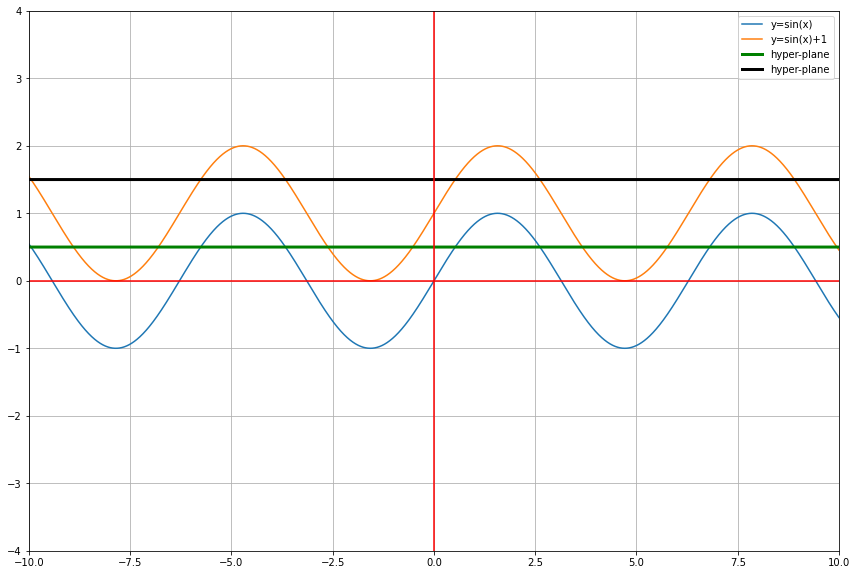

In [8]:
fig, axs = plt.subplots(1)
plt.subplots_adjust(top = 2, right=2, hspace = 0.3)

axs.set_xlim(-10, 10)
axs.set_ylim(-4, 4)
axs.plot(xlst, np.sin(xlst), label="y=sin(x)")
axs.plot(xlst, np.sin(xlst) + 1, label="y=sin(x)+1")
axs.plot(xlst, np.linspace(0.5, 0.5, len(xlst)), label="hyper-plane", color="green", lw=3)
axs.plot(xlst, np.linspace(1.5, 1.5, len(xlst)), label="hyper-plane", color="black", lw=3)
axs.axvline(x=0, color="r", lw=1.5)
axs.axhline(y=0, color="r", lw=1.5)
axs.grid(visible=True)

axs.legend()
plt.show()

**很显然，我们不可能找到一个线性函数将两组数据完美地区分开（像图中的绿线所示）。但如果应用神经网络呢？我们知道，对于二元分类问题，通常使用：**

$$
tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} \qquad \quad \text{或} \qquad \quad sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

**作为 activation function，假设这里用 sigmoid，那么我们对数据进行变换，如下图：**

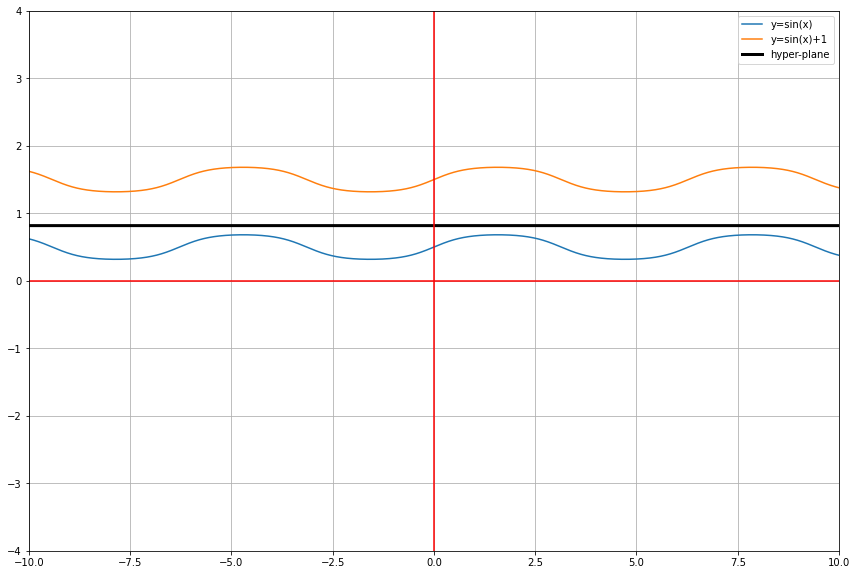

In [9]:
def sigmoid(arr):
    return 1 / (1 + np.exp(-arr))

fig, axs = plt.subplots(1)
plt.subplots_adjust(top = 2, right=2, hspace = 0.3)

axs.set_xlim(-10, 10)
axs.set_ylim(-4, 4)
axs.plot(xlst, sigmoid(np.tanh(np.sin(xlst))), label="y=sin(x)")
axs.plot(xlst, sigmoid(np.tanh(np.sin(xlst))) + 1, label="y=sin(x)+1")
axs.plot(xlst, sigmoid(np.linspace(1.5, 1.5, len(xlst))), label="hyper-plane", color="black", lw=3)
axs.axvline(x=0, color="r", lw=1.5)
axs.axhline(y=0, color="r", lw=1.5)
axs.grid(visible=True)

axs.legend()
plt.show()

**如上图，我们可以发现我们已经能用“一条直线”将两个函数区分开来。实际上，更为直观的理解是，我们在对坐标轴进行变换。在二维中，一次线性变换相当于将网格状的平面直角坐标系在固定原定不动的情况下“拉伸”成由平行四边形构成的新网状结构，但是在线性变换下，平面依然还是平面。**

![jupyter](attachments\\linear_transform.png)

**那么对于非线性变化，相当于将原先“平整”的面卷曲为曲率不一致的面。该如何理解这句话？假设我们希望对以下两条曲线进行分类：**

![jupyter](attachments\\affine1.png)

**从最简单的神经网络类开始，即只有输入层（input layer）和输出层（output layer）。这样的网络仅仅试图通过用一条线来分隔这两类数据：**

![jupyter](attachments\\affine2.png)

**以上的分类不够精准，或者称它是“失败的”。如果除了输入层和输出层以外，我们能够加上隐藏层（hidden layer），哪怕仅仅一层，我们就能够对整个坐标平面进行仿射变换（affine transformation），相当于对这个平面上任意一个向量、任意一条直线做相应的仿射变换，于是平面被卷曲如下图所示：**

![jupyter](attachments\\affine3.png)

**注意：以上的这个曲面并没有创造第三个维度，看似的凸起是由于这个面上曲率（或者说微分）的不一致。做一个类比，我们的地球表面是一个球面，但是只需要经度、纬度两个坐标就能确定点的位置。实际上，它是使用了一条比直线更复杂的曲线分割数据，而这条曲线在扭曲的坐标平面上“表现为”一条直线：**

![jupyter](attachments\\affine4.png)

再例如直线 $y = x$ 经过 $f(x)=tanh(x)$ 的变换，或者 $y=x$ 经过 $f$ 的扭曲，变为 $y^{'} = f(y(x)) = tanh(x)$，图象如下。

对于这条曲线上的所有点，它们本来全部满足 $y = x$，但经过仿射变成了曲线，试着从"level curve"的角度去理解。

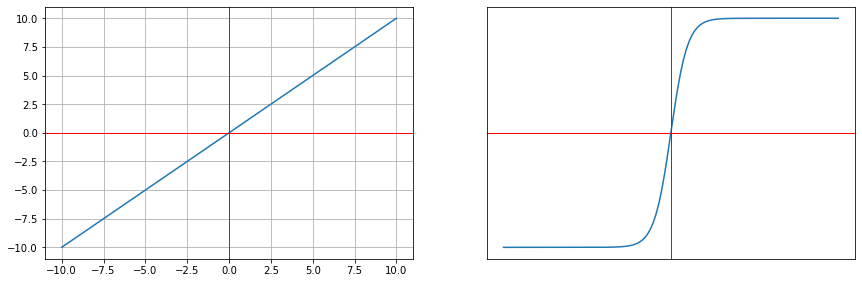

In [10]:
fig, axs = plt.subplots(1, 2)
plt.subplots_adjust(top = 1, right=2, hspace = 0.3)

axs[0].plot(xlst, xlst, antialiased=True)
axs[0].grid(visible=True)
axs[0].axvline(x=0, color="r", lw=1)
axs[0].axhline(y=0, color="r", lw=1)

axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].plot(xlst, np.tanh(xlst), antialiased=True)
axs[1].axvline(x=0, color="r", lw=1)
axs[1].axhline(y=0, color="r", lw=1)
plt.show()

**同理，$y = x - 1$ 和 $y = x + 1$ 也可以经过 $f(x) = tanh(x)$ 的变换，图象如下：**

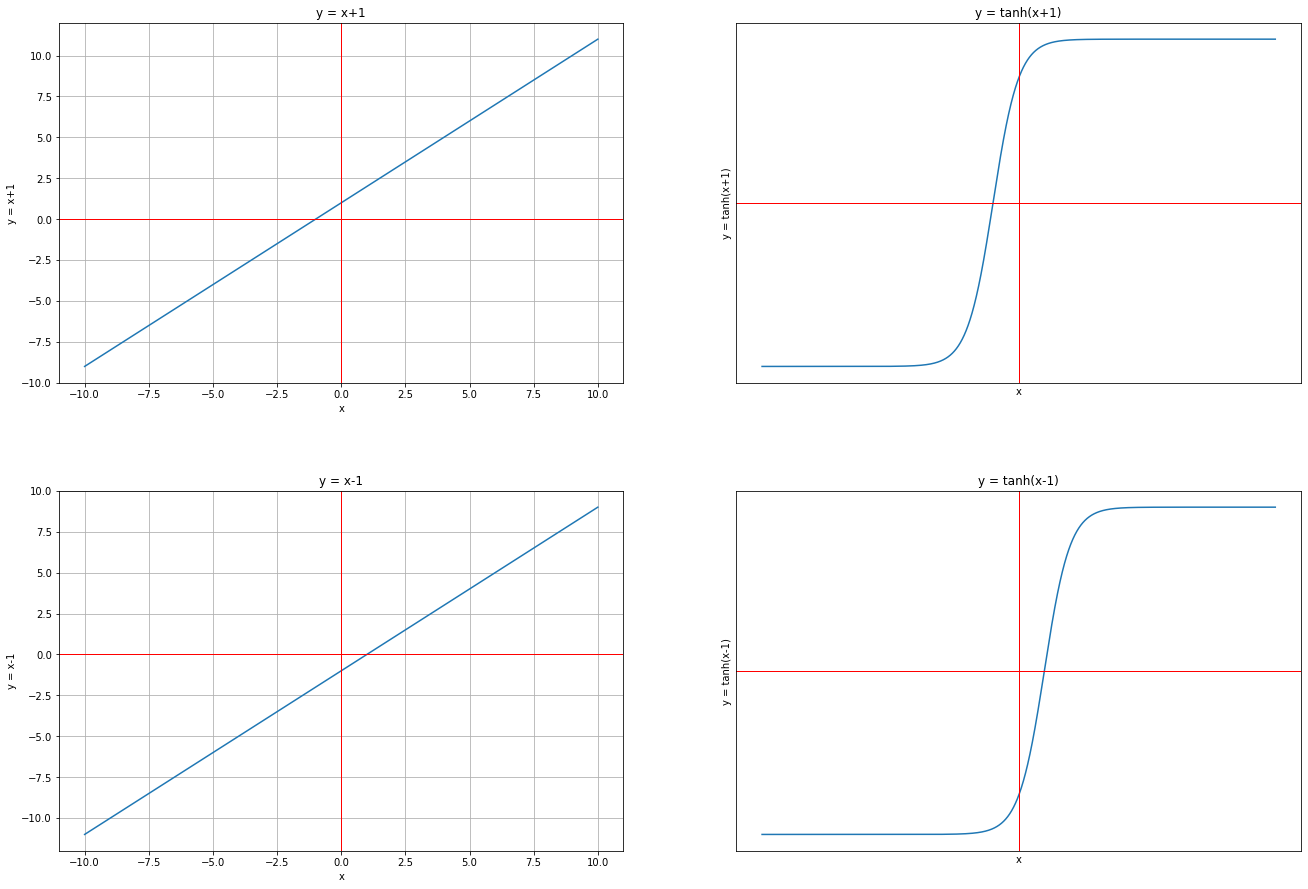

In [11]:
fig, axs = plt.subplots(2, 2)
plt.subplots_adjust(top = 3, right=3, hspace = 0.3)

axs[0, 0].plot(xlst, xlst+1, antialiased=True)
axs[0, 0].axvline(x=0, color="r", lw=1)
axs[0, 0].axhline(y=0, color="r", lw=1)
axs[0, 0].grid(visible=True)
axs[0, 0].set_title("y = x+1")
axs.flat[0].set(xlabel = "x", ylabel = "y = x+1")

axs[0, 1].plot(xlst, np.tanh(xlst+1), antialiased=True)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].axvline(x=0, color="r", lw=1)
axs[0, 1].axhline(y=0, color="r", lw=1)
axs[0, 1].grid(visible=True)
axs[0, 1].set_title("y = tanh(x+1)")
axs.flat[1].set(xlabel = "x", ylabel = "y = tanh(x+1)")


axs[1, 0].plot(xlst, xlst-1, antialiased=True)
axs[1, 0].axvline(x=0, color="r", lw=1)
axs[1, 0].axhline(y=0, color="r", lw=1)
axs[1, 0].grid(visible=True)
axs[1, 0].set_title("y = x-1")
axs.flat[2].set(xlabel = "x", ylabel = "y = x-1")


axs[1, 1].plot(xlst, np.tanh(xlst-1), antialiased=True)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[1, 1].axvline(x=0, color="r", lw=1)
axs[1, 1].axhline(y=0, color="r", lw=1)
axs[1, 1].grid(visible=True)
axs[1, 1].set_title("y = tanh(x-1)")
axs.flat[3].set(xlabel = "x", ylabel = "y = tanh(x-1)")

plt.show()

**假设我们有一系列平行的直线：$y = x, ~ y = x + 1, ~ y = x - 1, ~ y = x + 2, ~ y = x - 2, \ldots$，它们同时经过 $f(x) = tanh(x)$ 的仿射变换，如下图：**

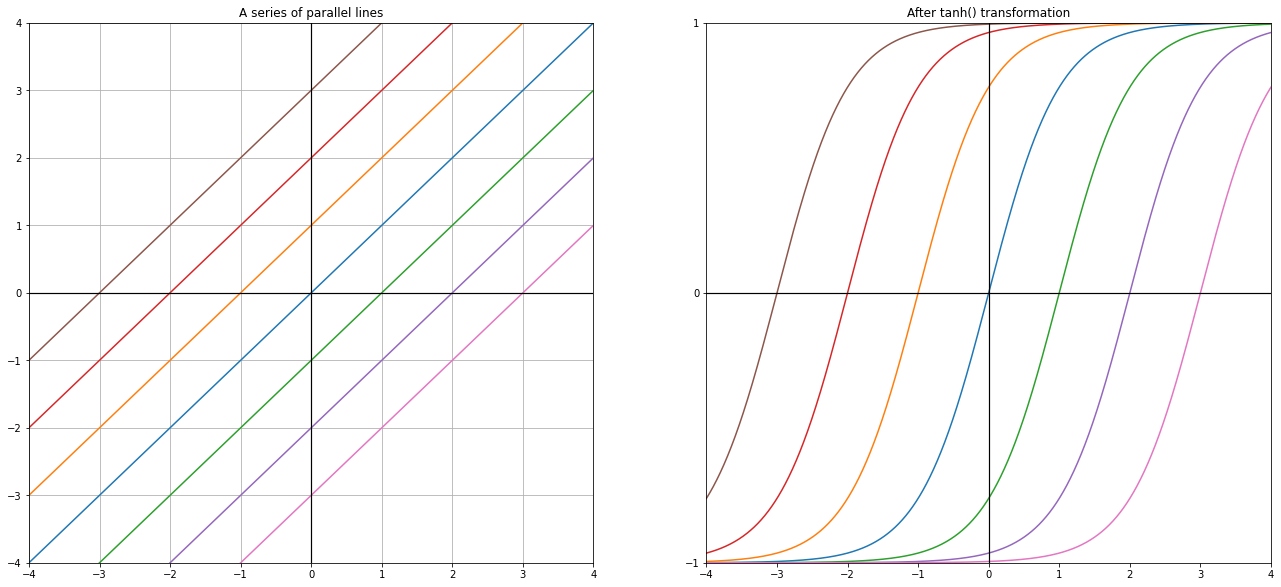

In [12]:
fig, axs = plt.subplots(1, 2)
plt.subplots_adjust(top = 2, right=3, hspace = 0.3)

axs[0].set_xlim(-4, 4)
axs[0].set_ylim(-4, 4)
axs[0].plot(xlst, xlst, antialiased=True)
axs[0].plot(xlst, xlst+1, antialiased=True)
axs[0].plot(xlst, xlst-1, antialiased=True)
axs[0].plot(xlst, xlst+2, antialiased=True)
axs[0].plot(xlst, xlst-2, antialiased=True)
axs[0].plot(xlst, xlst+3, antialiased=True)
axs[0].plot(xlst, xlst-3, antialiased=True)
axs[0].axvline(x=0, color="black", lw=1.2)
axs[0].axhline(y=0, color="black", lw=1.2)
axs[0].grid(visible=True)
axs[0].set_title("A series of parallel lines")


axs[1].set_xlim(-4, 4)
axs[1].set_ylim(-1, 1)
axs[1].set_yticks([-1, 0, 1])
axs[1].plot(xlst, np.tanh(xlst), antialiased=True)
axs[1].plot(xlst, np.tanh(xlst+1), antialiased=True)
axs[1].plot(xlst, np.tanh(xlst-1), antialiased=True)
axs[1].plot(xlst, np.tanh(xlst+2), antialiased=True)
axs[1].plot(xlst, np.tanh(xlst-2), antialiased=True)
axs[1].plot(xlst, np.tanh(xlst+3), antialiased=True)
axs[1].plot(xlst, np.tanh(xlst-3), antialiased=True)
axs[1].axvline(x=0, color="black", lw=1.2)
axs[1].axhline(y=0, color="black", lw=1.2)
axs[1].set_title("After tanh() transformation")

plt.show()

**因此可以想象用  𝑡𝑎𝑛ℎ(𝑥)  对二维坐标系进行仿射变换，如下图：**

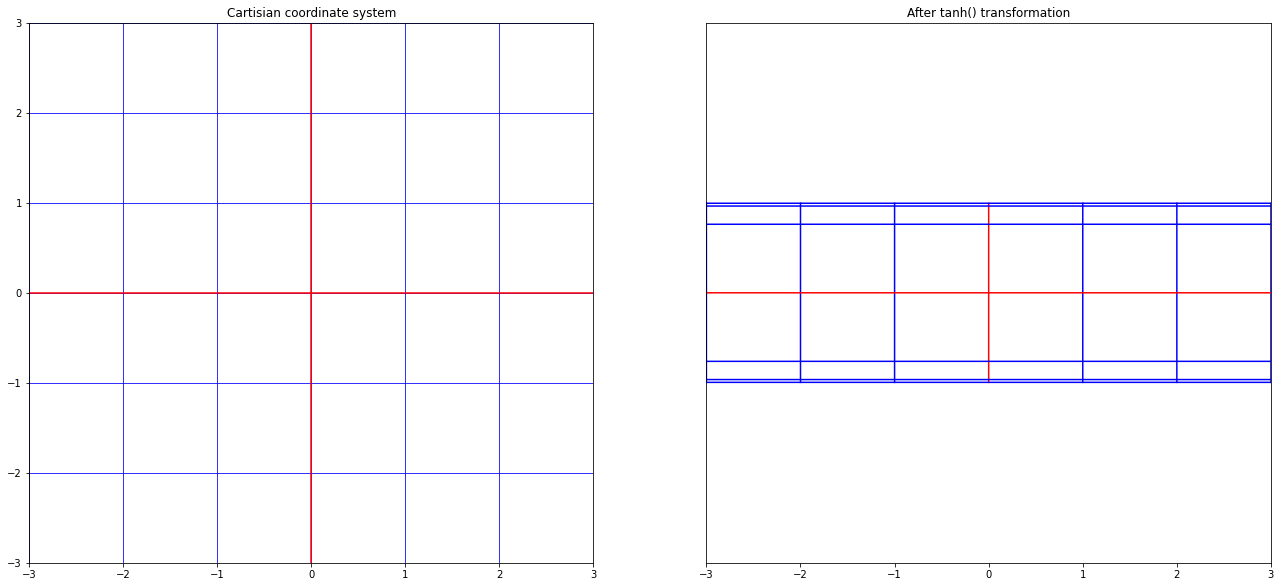

In [13]:
fig, axs = plt.subplots(1, 2)
plt.subplots_adjust(top = 2, right=3, hspace = 0.3)

axs[0].set_xlim(-3, 3)
axs[0].set_ylim(-3, 3)
axs[0].grid(visible=True, color="blue")
axs[0].axvline(x=0, color="red", lw=1.5)
axs[0].axhline(y=0, color="red", lw=1.5)
axs[0].set_title("Cartisian coordinate system")

axs[1].set_xlim(-3, 3)
axs[1].set_ylim(-3, 3)
axs[1].set_yticks([])
axs[1].plot(np.linspace(-3, -3, klen), np.tanh(klst), antialiased=True, color="blue")
axs[1].plot(np.linspace(-2, -2, klen), np.tanh(klst), antialiased=True, color="blue")
axs[1].plot(np.linspace(-1, -1, klen), np.tanh(klst), antialiased=True, color="blue")
axs[1].plot(np.linspace(0, 0, klen), np.tanh(klst), antialiased=True, color="red", lw=1.5)
axs[1].plot(np.linspace(1, 1, klen), np.tanh(klst), antialiased=True, color="blue")
axs[1].plot(np.linspace(2, 2, klen), np.tanh(klst), antialiased=True, color="blue")
axs[1].plot(np.linspace(3, 3, klen), np.tanh(klst), antialiased=True, color="blue")
axs[1].plot(klst, np.tanh(np.linspace(-3, -3, klen)), antialiased=True, color="blue")
axs[1].plot(klst, np.tanh(np.linspace(-2, -2, klen)), antialiased=True, color="blue")
axs[1].plot(klst, np.tanh(np.linspace(-1, -1, klen)), antialiased=True, color="blue")
axs[1].plot(klst, np.tanh(np.linspace(0, 0, klen)), antialiased=True, color="red", lw=1.5)
axs[1].plot(klst, np.tanh(np.linspace(1, 1, klen)), antialiased=True, color="blue")
axs[1].plot(klst, np.tanh(np.linspace(2, 2, klen)), antialiased=True, color="blue")
axs[1].plot(klst, np.tanh(np.linspace(3, 3, klen)), antialiased=True, color="blue")
axs[1].set_title("After tanh() transformation")

plt.show()

**上图为坐标轴区域 $(-3, 3) \times (-3, 3)$ 经过仿射变换出来的新的二维空间，就是一个y轴方向被卡死在 $(-1, 1)$，x轴方向依然延展到正负无穷的曲面空间。注意到右图中，y轴方向有 $7$ 条密度不均等的线，由上至下分别表示由左图
$$ 
y = 3, ~ 2, ~ 1, ~ 0, ~ -1, ~ -2, ~ -3
$$ 
直线仿射变换而来的新直线：
$$
y = \tanh (3), ~ \tanh (2), ~ \tanh (1), ~ \tanh (0), ~ \tanh (-3), ~ \tanh (-2), ~ \tanh (-1)
$$**

## 该曲面的曲率如何体现？
**这种曲率并不只由右图体现，而是由“从左图到右图点的一一映射”体现。**

令任意一函数 $g: \mathbb{R} \rightarrow E$，定义 $f: E \rightarrow \mathbb{R}$ 为激活函数，那么 
$$
h(x) := \left( f \circ g \right)(x) = f(g(x))
$$
为 $g$ 经 $f$ 变换后的函数。

我们可以想象在右图中近似画出 $\tanh x$ 的曲线，即从左下角顶点开始，沿着方格对角线以及对角线方格向右上方画出一条曲线。**尤其需要注意的是**，即便现在y轴上实际的刻度为：

$$
\tanh (3), ~ \tanh (2), ~ \tanh (1), ~ \tanh (0), ~ \tanh (-3), ~ \tanh (-2), ~ \tanh (-1)
$$

但是它依然代表着原坐标轴中的：

$$
3, ~ 2, ~ 1, ~ 0, ~ -1, ~ -2, ~ -3
$$

也就是说，对于一组数据，经过激活函数 $\tanh x$ 变换后，实质上只是在y轴方向对它们向中间进行了“挤压”。

这是因为对于任意点 $\left(x, g(x) \right)$，必存在唯一的 $\left(x, h(x)\right) = \left(x, f(g(x)\right)$ 与之对应（在上图中这代表着，对于任意左图中的点，必在右图中存在某点与之唯一对应），这意味着：

**激活函数 $f$ 为双射函数。**
（重要的是单射，满射非常显而易见)

并且：

**函数 $f$ 为双射当且仅当 $f$ 可逆。**

这解释了为什么几乎所有常见的激活函数（例如sigmoid，tanh，linear等等）都为双射、甚至严格单调函数，因为**严格单调函数必定为单射，也必定存在反函数**（当然这是充分不必要条件）。而非单射的激活函数（例如ReLU）会存在一些问题，例如 **The dying ReLU problem**。

## 为什么激活函数需要为双射函数？
（这里我给出两种解释，第一种偏直觉，第二种偏数学且严格。）

**Intuitively speaking**，一组数据代表着一定量的信息，理想情况下，即使经过隐藏层中激活函数的变换，数据的信息也不能被丢失或扭曲（显然ReLU函数：$\max(0, x)$ 造成了信息的丢失）。

假设函数 $f: E \rightarrow \mathbb{R}$ 不为单射，那么：
$$
\exists y_{1}, y_{2} \in E, y_{1} \neq y_{2}: ~ f(y_{1}) = f(y_{2})
$$

那么两个不同的数据点 $(x_{1}, y_{1}), ~ (x_{2}, y_{2})$ 变换后指向了同一个函数值，这造成了信息的丢失以及扭曲。

**Mathematically speaking**，通过以上的例子，并结合之前跳过的transfer function部分： 
$$
\bf W \cdot \vec{x} + b
$$

拨云见日地容易理解神经网络背后的数学原理，即：**拓扑（topology）**。

# 来点数学

### Definition 1. (Metric: 度量) 
令 $X$ 为一个集合，定义在 $X$ 上的一个距离 (distance) 或 度量 (metric) 为一个函数：

$$
d: X \times X \rightarrow \mathbb{R}^{+}
$$

且应当满足：
* 对于 $\forall x, y \in X$，当且仅当 $x = y$ 时有 $d(x, y) = 0$
* 对于 $\forall x,y \in X: ~ d(x, y) = d(y, x) \qquad \qquad \qquad \quad ~$ (Symmetry)
* 对于 $\forall x, y, z \in X: ~ d(x, z) \leq d(x, y) + d(y, z) \qquad \quad $ (Triangle inequality)

### Definition 2. (Metric Space: 度量空间)
一个度量空间记作 $(X, d)$，其中 $X$ 是一个集合，$d$ 为定义在 $X$ 上的一个距离。

### Definition 3. (Isometry: 等距映射)
令 $(X, d_{X}), ~ (Y, d_{Y})$ 为两个度量空间。一个isometry（等距映射）是一个函数：$\phi: X \rightarrow Y$，使得：

* 对于 $\forall x_{1}, x_{2} \in X: ~ d_{Y}\big(\phi(x_{1}), \phi(x_{2})\big) = d_{X}\big( x_{1}, x_{2} \big)$。

* $\phi$ 是满射的（surjective），即：$\forall y \in Y: \exists x \in X: \phi (x) = y$

### Corollary 1.
由 Definition 3 很容易得到推论：一个 isometry 必定是单射的（injective）。

证明：设有任意两点 $x_{1}, x_{2} \in X$，满足 $\phi(x_{1}) = \phi(x_{2})$。由以上度量的定义：

$$
\begin{align*}
\phi(x_{1}) = \phi(x_{2}) & \iff d_{Y}\big( \phi(x_{1}),~\phi(x_{2}) \big) = 0\\
& \iff d_{X}(x_{1},~x_{2}) = 0\\
& \iff x_{1} = x_{2}
\end{align*}
$$

因此，一个 isometry 同时为单射和满射，说明 isometry 是双射的。

### Definition 4.
对于两个度量空间 $(X, d_{X}),~(Y, d_{Y})$，若它们之间存在一个isometry: $\phi: (X, d_{X}) \rightarrow (Y, d_{Y})$，则称这两个度量空间是等距的（isometric）。

### Definition 5. (Continuity in metric spaces)
令 $(X, d_{X}), (Y, d_{Y})$ 为两个 metric spaces，令 $f: X \rightarrow Y$ 为一个函数，令 $x_{0} \in X, l \in Y$。那么函数 $f$ 在 $x_{0} \in X$ 上连续定义为:

$$
\mbox{for } \forall \epsilon > 0: ~ \exists \delta > 0: ~ \forall x \in \left\{x : 0 < d_{X}(x, x_{0}) < \delta \right\}: ~ d_{Y}\big( f(x), f(x_{0}) \big) < \epsilon
$$

或者：

$$
\forall \epsilon > 0: ~ \exists \delta > 0: ~ f \big( B^{d_{X}}_{\delta}(x_{0}) \big) \subset B^{d_{Y}}_{\epsilon}(f(x_{0}))
$$

其中 $B$ 代表超球。

当对于 $\forall x_{0} \in X$， 函数 $f$ 在 $x_{0}$ 上都连续，则称函数 $f$ 连续。

### Definition 6. (Topology: 拓扑)
定义在集合 $X$ 上的一个拓扑 $\tau$ 是由 $X$ 的子集构成的集类，使满足：

* $\emptyset, X \in \tau$

* $A_{i} \in \tau ~ $ for $ ~ \forall i \in I \quad \implies \quad \bigcup\limits_{i \in I} A_{i} \in \tau \qquad $ (Closed under countable or uncountable unions)
* $A_{1}, \ldots, A_{N} \in \tau \qquad \implies \quad \bigcap\limits_{i=1}^{N} A_{i} \in \tau \qquad$ (Closed under finite intersections) 

一个 topological space（拓扑空间）可表示为 $(X, \tau )$，其中 $\tau$ 为 $X$ 上的拓扑。

### Theorem.
令 $(X, d_{X}), (Y, d_{Y})$ 为两个度量空间，令 $f: X \rightarrow Y$，那么以下是等价的：

1. $f$ 是连续的。
2. 对于任意的 open set： $O \subset Y$， $f^{-1}(O)$ 为 $(X, d_{X})$ 上的 open set。

**证明：**

$1 \rightarrow 2:$

假设 $f$ 是连续函数，那么对于任意的 $x \in X$ 以及任意的 $\epsilon > 0$，都存在一个 $\delta > 0$ s.t. $f \big( B^{d_{X}}_{\delta}(x) \big) \subset B^{d_{Y}}_{\epsilon}(f(x))$，那么：

$$
f^{-1} \Big( f\big(B^{d_{X}}_{\delta}(x) \big) \Big) = B^{d_{X}}_{\delta}(x) \subset f^{-1}\big( B^{d_{Y}}_{\epsilon}(f(x))\big)
$$

现在假设 $f(x_{0}) \in O \subset Y$，则 $x_{0} \in f^{-1}(O) \subset X$。由于 $O$ 是 open set，那么我们可以找到一个开球：$B_{\epsilon}(f(x_{0})) \subset O$。同时由于 $f$ 在 $x_{0}$ 处连续，那么可以找到一个 $\delta >  0$ 使得：

$$
B_{\delta}(x_{0}) \subset f^{-1}\big(B_{\epsilon}(f(x_{0}))\big)
$$

因此 $B_{\delta}(x_{0}) \subset f^{-1}(B_{\epsilon}(f(x_{0}))) \subset f^{-1}(O)$，所以 $f^{-1}(O)$ 是 $(X, d_{X})$ 上的 open set。

$2 \rightarrow 1:$

相反方向的证明较为简单。假设对于 $x_{0} \in X$， 存在 $\epsilon > 0$，使得对于任意的 $\delta > 0$, $f\big( B^{d_{X}}_{\delta} \big)$ 都不为 $B^{d_{Y}}_{\epsilon}\big( f(x_{0}) \big)$ 的子集，但这是不可能的，因为 $B_{\epsilon}^{d_{Y}}(f(x_{0}))$ 本身就是一个开球。

### Definition 7. (Homeomorphism: 同胚映射)

令 $(X, \tau_{X}), (Y, \tau_{Y})$ 为两个拓扑空间。称函数 $f: (X, \tau_{X}) \rightarrow (Y, \tau_{Y})$ 是一个 homeomorphism（同胚映射），如果：

* f 为双射
* f 和 f^{-1} 都为连续

当 $(X, \tau_{X})$ 和 $(Y, \tau_{Y})$ 之间存在这种同胚映射时，称两个拓扑空间是同胚的（Homeomorphic）。

形象地说，同胚是对一个几何体进行连续地拉伸或弯曲（但绝不能进行切割或折叠），虽然前后形状发生了改变，但是在拓扑学中认为前后两几何体同胚（本文中一个数据集通过对自身的变换的情况叫“自同胚”），意味着它们的拓扑性质完全相同，它们是“等价的”。做一个不恰当的类比，我们将实际生活中的电路抽象为横平竖直的电路图，它们之间可以看作是“同胚的”，因为在画图时对导线、接点作出的调整不影响其性质。

### 回到 DL 的问题

从以上我们的说明可以发现，$\tanh$ 作为激活函数具有非常优秀的性质，因为数据经过 $\tanh$ 层前后是同胚的。这涉及一个重要的定理。

### Theorem. 
**对于 $\tanh$ 层，若输入和输出的数据维度都为 $N$，且权重矩阵 $W$ 是非奇异（即可逆）的，那么输入数据与输出数据同胚。**

**证明：**
首先，$W$ 具有非零行列式，因此 transfer function 是一个可逆的的双射线性函数，而线性函数是连续的。所以，经过transfer function： $\bf W\cdot x + b$ 前后是同胚。同时，$\tanh$ 是连续可逆函数，并且当且仅当函数为双射时函数可逆，因此同胚性质逐点可证。

**我们可以用拓扑理解更复杂的网络。例如，以下网络使用四个隐藏层对两个稍微纠缠的螺旋进行分类。随着时间的推移，我们可以看到它从“原始”表示形式转变为它为了对数据进行分类而学到的更高级别的表示形式。虽然螺旋线最初是纠缠在一起的，但到最后它们是线性可分离的。**

![jupyter](attachments\\spiral1.gif)

**相似的一个反例：以下神经网络则不能对两条螺旋线实现分类：**

![jupyter](attachments\\spiral4.gif)

**另一个例子可以解释 transfer function 发挥的作用。以下红色与蓝色分别代表二维数据集 $A,~ B \subset \mathbb{R}^{2}$：**

$$
\begin{align*}
A & = \left\{x : d(x，0) < \frac{1}{3} \right\}\\
B & = \left\{x : \frac{2}{3} < d(x，0) < 1 \right\}
\end{align*}
$$

![jupyter](attachments\\spiral2.png)

**如果只有两个hidden units（即neurons），神经网络在拓扑上则无法以这种方式分离数据，并注定会在此数据集上失败。以下的可视化能观察到神经网络训练时蕴含的分类过程以及用于分类的超平面。我们可以看到神经网络算法挣扎着、试图学习一种分类方法。最后，它被拖入一个无效的局部最小值。虽然，它实际上能够实现大约80%分类准确性。此示例只有一个隐藏层（hidden layer），但无论如何都会失败：**

![jupyter](attachments\\spiral3.gif)

**如果我们添加第三个隐藏单元，问题就变得微不足道了。神经网络学习以下表示：**
![jupyter](attachments\\spiral5.png)

**通过以上这种表示，我们可以用一个超平面分离数据集。为了更好地了解正在发生的事情，让我们考虑一个更简单的一维数据集：**

$$
\begin{align*}
A &= \left[ -\frac{1}{3}, \frac{1}{3} \right] \\
B &= \left[ -1, -\frac{2}{3} \right] \cup \left[ \frac{2}{3}, 1 \right]
\end{align*}
$$

**即：**

![jupyter](attachments\\spiral6.png)

**如果不使用$\geq 3$ 个神经元（neurons），则无法对此数据集进行分类。但是，如果我们加上一个具有两个神经元的hidden layer（原本有1个），我们就会学会将数据表示为一条漂亮的曲线，这使我们能够用一条线来分隔类：**

![jupyter](attachments\\spiral7.gif)


**这个神经网络加上两个额外的神经元后发生了什么？即，一个神经元可以识别 $x > -\frac{1}{2}$ 的情况，另一个可以识别 $x > \frac{1}{2}$ 的情况。对一个数据点，当仅仅前者发挥了作用，我们知道 $x > -\frac{1}{2}$ 而 $x \leq \frac{1}{2}$，则说明这个数据点属于集合A。**

# 后向传播算法 （Backpropagation）

**本质是链式法则，直接附例题：**

![jupyter](attachments\\chain_rule.png)

In [14]:
# 根据上图进行一次 backpropagation 更新权重的算法：
def sigmoid(p):
    return 1/(1+math.exp(-p))

def backpropagation(x=1, y=4, z=5, target=np.array([0.1, 0.05]), lr=0.01):
    w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 = 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.1
    h_1, h_2 = sigmoid(w1*x + w3*y + w5*z + 0.5), sigmoid(w2*x + w4*y + w6*z + 0.5)
    o_1, o_2 = sigmoid(w7*h_1 + w9*h_2 + 0.5), sigmoid(w8*h_1 + w10*h_2 + 0.5)
    sse = 1/2 * sum((target-np.array([o_1, o_2]))**2)
    sse_o1, sse_o2 = o_1 - target[0], o_2 - target[1]
    o1_n1, o2_n2 = o_1 * (1 - o_1), o_2 * (1 - o_2)
    n1_w7, n1_w9, n2_w8, n2_w10 = h_1, h_2, h_1, h_2
    sse_w7, sse_w8 = sse_o1 * o1_n1 * n1_w7, sse_o2 * o2_n2 * n2_w8
    sse_w9, sse_w10 = sse_o1 * o1_n1 * n1_w9, sse_o2 * o2_n2 * n2_w10
    new_w7, new_w8, new_w9, new_w10 = w7 + lr * n1_w7, w8 + lr * n2_w8, w9+ lr * n1_w9, w10 + lr * n2_w10
    h1_m1, h2_m2 = h_1 * (1 - h_1), h_2 * (1 - h_2)
    m1_w1, m1_w3, m1_w5, m2_w2, m2_w4, m2_w6 = w1, w3, w5, w2, w4, w6
    h1_w1, h1_w3, h1_w5 = h1_m1 * m1_w1, h1_m1 * m1_w3, h1_m1 * m1_w5
    h2_w2, h2_w4, h2_w6 = h2_m2 * m2_w2, h2_m2 * m2_w4, h2_m2 * m2_w6
    n1_h1, n1_h2, n2_h1, n2_h2 = w7, w9, w8, w10
    sse_h1, sse_h2 = o1_n1 * n1_h1 + o2_n2 * n2_h1, o1_n1 * n1_h2 + o2_n2 * n2_h2
    sse_m1, sse_m2 = sse_h1 * h1_m1, sse_h2 * h2_m2
    sse_w1, sse_w3, sse_w5 = sse_h1 * h1_w1, sse_h1 * h1_w3, sse_h1 * h1_w5
    sse_w2, sse_w4, sse_w6 = sse_h2 * h2_w2, sse_h2 * h2_w4, sse_h2 * h2_w6
    new_w1, new_w3, new_w5 = w1 + lr * sse_w1, w3 + lr * sse_w3, w5 + lr * sse_w5
    new_w2, new_w4, new_w6 = w2 + lr * sse_w2, w4 + lr * sse_w4, w6 + lr * sse_w6
    return {"new w1": new_w1, "new w2": new_w2, "new w3": new_w3, "new w4": new_w4, "new w5": new_w5, 
            "new w6": new_w6, "new w7": new_w7, "new w8": new_w8, "new w9": new_w9, "new w10": new_w10}

backpropagation()

{'new w1': 0.10000259641466082,
 'new w2': 0.2000010319300706,
 'new w3': 0.3000077892439824,
 'new w4': 0.4000020638601412,
 'new w5': 0.500012982073304,
 'new w6': 0.6000030957902117,
 'new w7': 0.7098661308217233,
 'new w8': 0.8098661308217234,
 'new w9': 0.9099503319834995,
 'new w10': 0.10995033198349943}

# Data Preparation

In [15]:
# Import the data
price_file = open("C:\\Users\\tianj\\Desktop\\" + 
                 "Causis\\data\\股票行情及估值数据\\stock_price_standard_", "rb")
st_file = open("C:\\Users\\tianj\\Desktop\\" + 
               "Causis\\data\\股票行情及估值数据\\stock_st_standard_", "rb")
factor_file = open("C:\\Users\\tianj\\Desktop\\" + 
                  "Causis\\data\\股票行情及估值数据\\stock_valuation_standard_", "rb")

price = pickle.load(price_file)
st = pickle.load(st_file)
factor = pickle.load(factor_file)

In [16]:
price = price.reset_index().rename(columns={"level_0": "code"}).rename(columns={"level_1": "item"})
price["code"] = list(map(lambda i: re.findall(pattern="[\d]{6}", string=i)[0], price["code"]))
price = price.set_index(["code", "item"]).T
price.index.name = "date"

In [17]:
st = st.reset_index().rename(columns={"level_0": "code"}).rename(columns={"level_1": "item"})
st["code"] = list(map(lambda i: re.findall(pattern="[\d]{6}", string=i)[0], st["code"]))
st = st.set_index(["code", "item"]).T
st.index.name = "date"

In [18]:
factor = factor.reset_index().rename(columns={"level_0": "code"}).rename(columns={"level_1": "item"})
factor["code"] = list(map(lambda i: re.findall(pattern="[\d]{6}", string=i)[0], factor["code"]))
factor = factor.set_index(["code", "item"]).T
factor.index.name = "date"

In [19]:
print(f"Identical underlying assets?     {list(price.stack().columns) == list(st.stack().columns) == list(factor.stack().columns)}")
print(f"Identical time interval?     {list(price.index) == list(st.index) == list(factor.index)}")

Identical underlying assets?     True
Identical time interval?     True


In [20]:
stock_codes, trading_dates = np.array(price.stack().columns), np.array(price.index)

In [21]:
def count_daily_underlyings(row):
    return int(min(len(price.loc[row.name].dropna()) / 11, 
                   len(st.loc[row.name].dropna()) / 2, 
                   len(factor.loc[row.name].dropna()) / 10))

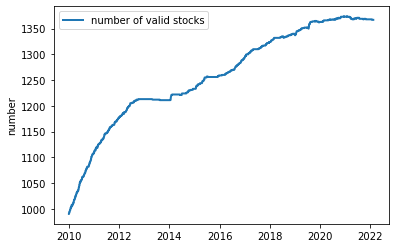

In [22]:
# ST stocks are not excluded till now.
plt.plot(price.apply(count_daily_underlyings, axis = 1), lw=2, label="number of valid stocks")
plt.legend()
plt.ylabel(ylabel="number")
plt.show()

# Dataset Splitting and Scrubbing

In [23]:
# 剔除凡是被ST过的股票
good_codes = np.array(st[np.array(list(map(lambda col: col if col[1]=="IsST" else None, st.columns)))[
    np.array(list(map(lambda col: col if col[1]=="IsST" else None, st.columns))) != None]
                      ].sum().reset_index().set_index("code").drop(columns=["item"]).iloc[:, 0][st[
    np.array(list(map(lambda col: col if col[1]=="IsST" else None, st.columns)))[
        np.array(list(map(lambda col: col if col[1]=="IsST" else None, st.columns))) != None
    ]].sum().reset_index().set_index("code").drop(columns=["item"]).iloc[:, 0] == 0].index)

stock_codes = good_codes.copy()
price = price[good_codes]
factor = factor[good_codes]
del good_codes

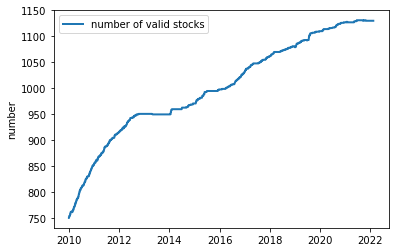

In [24]:
# Number of valid stocks available after cleaning stocks.
plt.plot(price.apply(count_daily_underlyings, axis = 1), lw=2, label="number of valid stocks")
plt.legend()
plt.ylabel(ylabel="number")
plt.show()

del st

Since the stock prices can be regarded as stochastic process $\mathbf{\left( X_{t} \right)_{t \geq 0}}$ with respect to time, or simply a time series $\mathbf{\left\{ X_{t} \right\}}$, hence with reference to the above two time series plots, which both represent a concave trend of number of valid stocks available on the market along with time, our model can reasonably choose about **85%** of remaining data as training data, where the other **15%** of data approximately would therefore be considered as test dataset.

In [25]:
good_stocks = np.array(np.isnan(price).sum().reset_index().groupby("code").agg({0: np.mean})[
    np.isnan(price).sum().reset_index().groupby("code").agg({0: np.mean}) == 0].dropna().index)

price = price[good_stocks]
factor = factor[good_stocks]
stock_codes = good_stocks.copy()
del good_stocks

In [26]:
# Check if any missing values.
factor.isna().sum().sum() == price.isna().sum().sum() == 0

True

In [27]:
# Check if the time interval stay consistency.
price.shape[0] == factor.shape[0]

True

In [28]:
price = price.unstack().reset_index().set_index("item")
price = price[price.index == "Close"].reset_index().drop(
    "item", axis=1).set_index("code").rename(columns={0: "Close"})

In [29]:
df = price.loc[stock_codes[0]].set_index("date").rename(columns={"Close": stock_codes[0]})
for code in stock_codes[1:]:
    df[code] = price.loc[code].set_index("date").rename(columns={"Close": code})[code]
price = df.copy()
del df

In [30]:
# Define a function that plot relevant time series with respect to PRICE.
def price_plot(code):
    """
    This function plots relevant time series information with respect to PRICE.

    code: str, the code of the objective stock.
    """
    
    traces = []
    trace = plotly.graph_objs.Scattergl(
        x = price.index,
        y = price[code]
    )

    traces.append(trace)

    layout = plotly.graph_objs.Layout(
        title = "Plot price information: Close for stock: " + code
    )
    
    fig = plotly.graph_objs.Figure(data=traces, layout=layout)

    plotly.offline.init_notebook_mode(connected=True)
    return plotly.offline.iplot(fig, filename="dataplot")

In [31]:
price_plot(code=random.choice(stock_codes))

In [32]:
# Define a function that plot relevant time series with respect to FACTOR.
def factor_plot(code, target="PeRatio"):
    """
    This function plots relevant time series information with respect to FACTOR.

    code: str, the code of the objective stock.
    """
    
    traces, df = [], factor.reset_index().sort_values("date")

    # mode = "line",   line = dict(color = "blue")
    trace = plotly.graph_objs.Scattergl(
        x = df["date"],
        y = df[(code, target)]
    )

    traces.append(trace)

    layout = plotly.graph_objs.Layout(
        title = "Plot factor information: " + target + " for stock: " + code
    )
    
    fig = plotly.graph_objs.Figure(data=traces, layout=layout)

    plotly.offline.init_notebook_mode(connected=True)
    return plotly.offline.iplot(fig, filename="dataplot")

In [33]:
for target in ["PeRatio", "CirculatingMarketCap", "TurnoverRatio"]:
    factor_plot(code=random.choice(stock_codes), target=target)

In [34]:
# Define a function that plot the graph of the backtest result.
def result_plot(x, y, title):
    """
    This function plots relevant time series information with respect to FACTOR.

    code: str, the code of the objective stock.
    """
    
    traces, df = [], factor.reset_index().sort_values("date")

    # mode = "line",   line = dict(color = "blue")
    trace = plotly.graph_objs.Scattergl(x=x, y=y)

    traces.append(trace)

    layout = plotly.graph_objs.Layout(title = title)
    
    fig = plotly.graph_objs.Figure(data=traces, layout=layout)

    plotly.offline.init_notebook_mode(connected=True)
    return plotly.offline.iplot(fig, filename="dataplot")

### Daily Return

In [35]:
df = (price.shift(-1) - price) / price
df.dropna(inplace=True)

# Grid Search

In [36]:
[train, test] = train_test_split(df, test_size=0.1, shuffle=False)

In [37]:
window_lst = range(10, 31)
epoch_lst = range(10, 101, 2)
neuron_lst = np.arange(24, 148, 4)
dropout_lst = np.arange(0, 0.5, 0.05)

In [38]:
def build_model(inputs, output_size, neurons, activ_func="linear", 
                dropout=0.10, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

def make_train_window(training_set, window):
    LSTM_training_inputs = np.array([np.array(training_set[i: (i+window)].copy()) 
                                     for i in range(len(training_set)-window)])
    LSTM_training_outputs = training_set.iloc[window: ].values
    return LSTM_training_inputs, LSTM_training_outputs

def make_test_window(test_set, window):
    LSTM_test_inputs = np.array([np.array(test_set[i:(i+window)].copy()) 
                                 for i in range(len(test_set)-window)])
    LSTM_test_outputs = test_set.iloc[window:].values
    return LSTM_test_inputs, LSTM_test_outputs

## Grid Search: Window length

split_date: 2020-10-26 00:00:00
Epoch 1/20
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/20
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/20
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/20
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/20
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/20
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/20
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/20
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/20
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/20
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/20
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 12/20
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/20
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/20
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/20
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Epoch 16/20
2615/

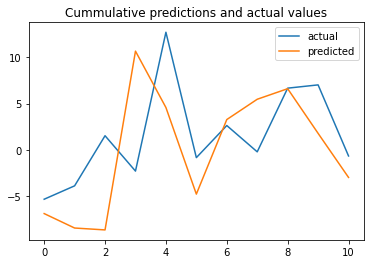

split_date: 2020-10-22 00:00:00
Epoch 1/20
2612/2612 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/20
2612/2612 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/20
2612/2612 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/20
2612/2612 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/20
2612/2612 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/20
2612/2612 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/20
2612/2612 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/20
2612/2612 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 9/20
2612/2612 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/20
2612/2612 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/20
2612/2612 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/20
2612/2612 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/20
2612/2612 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/20
2612/2612 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/20
2612/2612 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Epoch 16/20
2612/

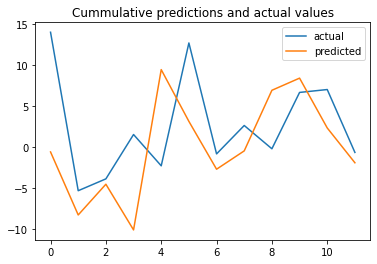

split_date: 2020-10-20 00:00:00
Epoch 1/20
2609/2609 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/20
2609/2609 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/20
2609/2609 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/20
2609/2609 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/20
2609/2609 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/20
2609/2609 - 6s - loss: 0.0181 - 6s/epoch - 2ms/step
Epoch 7/20
2609/2609 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/20
2609/2609 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 9/20
2609/2609 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/20
2609/2609 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/20
2609/2609 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 12/20
2609/2609 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 13/20
2609/2609 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/20
2609/2609 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/20
2609/2609 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 16/20
2609/

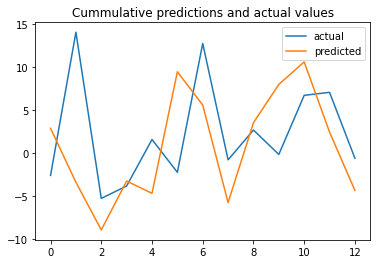

split_date: 2020-10-16 00:00:00
Epoch 1/20
2606/2606 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/20
2606/2606 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/20
2606/2606 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/20
2606/2606 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/20
2606/2606 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/20
2606/2606 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/20
2606/2606 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/20
2606/2606 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/20
2606/2606 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/20
2606/2606 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/20
2606/2606 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 12/20
2606/2606 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/20
2606/2606 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/20
2606/2606 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/20
2606/2606 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Epoch 16/20
2606/

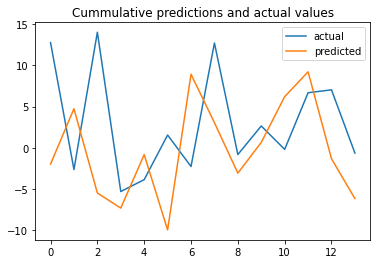

split_date: 2020-10-14 00:00:00
Epoch 1/20
2603/2603 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/20
2603/2603 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/20
2603/2603 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/20
2603/2603 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/20
2603/2603 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/20
2603/2603 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/20
2603/2603 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 8/20
2603/2603 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/20
2603/2603 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/20
2603/2603 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/20
2603/2603 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/20
2603/2603 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/20
2603/2603 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/20
2603/2603 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/20
2603/2603 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 16/20
2603/

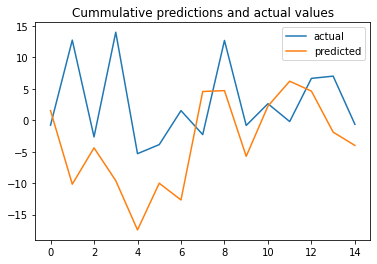

split_date: 2020-10-12 00:00:00
Epoch 1/20
2600/2600 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/20
2600/2600 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/20
2600/2600 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/20
2600/2600 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/20
2600/2600 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/20
2600/2600 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/20
2600/2600 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/20
2600/2600 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/20
2600/2600 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/20
2600/2600 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/20
2600/2600 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/20
2600/2600 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/20
2600/2600 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/20
2600/2600 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/20
2600/2600 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Epoch 16/20
2600/

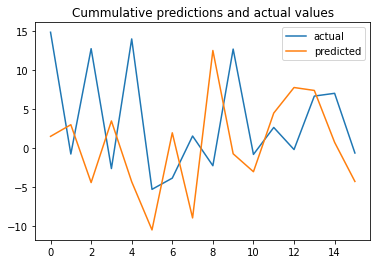

split_date: 2020-09-30 00:00:00
Epoch 1/20
2597/2597 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/20
2597/2597 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/20
2597/2597 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/20
2597/2597 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/20
2597/2597 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/20
2597/2597 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/20
2597/2597 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/20
2597/2597 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 9/20
2597/2597 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/20
2597/2597 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 11/20
2597/2597 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 12/20
2597/2597 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 13/20
2597/2597 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/20
2597/2597 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/20
2597/2597 - 6s - loss: 0.0157 - 6s/epoch - 2ms/step
Epoch 16/20
2597/

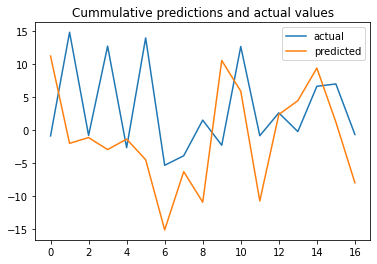

split_date: 2020-09-28 00:00:00
Epoch 1/20
2594/2594 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/20
2594/2594 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/20
2594/2594 - 7s - loss: 0.0189 - 7s/epoch - 3ms/step
Epoch 4/20
2594/2594 - 7s - loss: 0.0185 - 7s/epoch - 3ms/step
Epoch 5/20
2594/2594 - 7s - loss: 0.0182 - 7s/epoch - 3ms/step
Epoch 6/20
2594/2594 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/20
2594/2594 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/20
2594/2594 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 9/20
2594/2594 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/20
2594/2594 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 11/20
2594/2594 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 12/20
2594/2594 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 13/20
2594/2594 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 14/20
2594/2594 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Epoch 15/20
2594/2594 - 7s - loss: 0.0157 - 7s/epoch - 3ms/step
Epoch 16/20
2594/

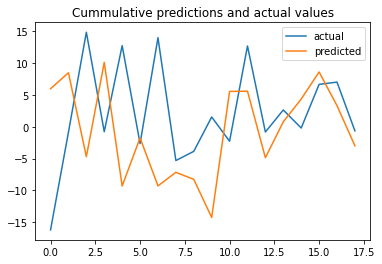

split_date: 2020-09-24 00:00:00
Epoch 1/20
2591/2591 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/20
2591/2591 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/20
2591/2591 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/20
2591/2591 - 6s - loss: 0.0187 - 6s/epoch - 3ms/step
Epoch 5/20
2591/2591 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/20
2591/2591 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/20
2591/2591 - 7s - loss: 0.0177 - 7s/epoch - 3ms/step
Epoch 8/20
2591/2591 - 6s - loss: 0.0174 - 6s/epoch - 3ms/step
Epoch 9/20
2591/2591 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/20
2591/2591 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/20
2591/2591 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 12/20
2591/2591 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/20
2591/2591 - 7s - loss: 0.0161 - 7s/epoch - 3ms/step
Epoch 14/20
2591/2591 - 6s - loss: 0.0159 - 6s/epoch - 3ms/step
Epoch 15/20
2591/2591 - 6s - loss: 0.0158 - 6s/epoch - 3ms/step
Epoch 16/20
2591/

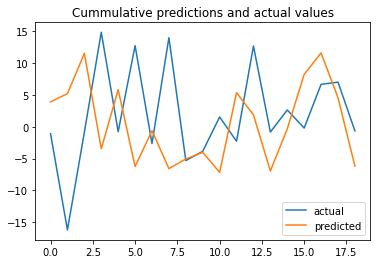

split_date: 2020-09-22 00:00:00
Epoch 1/20
2588/2588 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/20
2588/2588 - 6s - loss: 0.0191 - 6s/epoch - 3ms/step
Epoch 3/20
2588/2588 - 6s - loss: 0.0190 - 6s/epoch - 3ms/step
Epoch 4/20
2588/2588 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/20
2588/2588 - 7s - loss: 0.0182 - 7s/epoch - 3ms/step
Epoch 6/20
2588/2588 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/20
2588/2588 - 7s - loss: 0.0176 - 7s/epoch - 3ms/step
Epoch 8/20
2588/2588 - 6s - loss: 0.0172 - 6s/epoch - 3ms/step
Epoch 9/20
2588/2588 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 10/20
2588/2588 - 7s - loss: 0.0167 - 7s/epoch - 3ms/step
Epoch 11/20
2588/2588 - 7s - loss: 0.0164 - 7s/epoch - 3ms/step
Epoch 12/20
2588/2588 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step
Epoch 13/20
2588/2588 - 7s - loss: 0.0160 - 7s/epoch - 3ms/step
Epoch 14/20
2588/2588 - 7s - loss: 0.0159 - 7s/epoch - 3ms/step
Epoch 15/20
2588/2588 - 7s - loss: 0.0157 - 7s/epoch - 3ms/step
Epoch 16/20
2588/

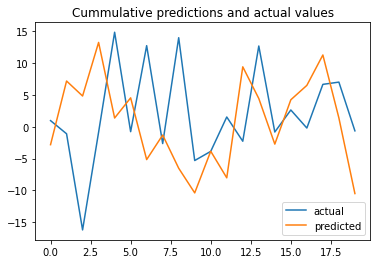

split_date: 2020-09-18 00:00:00
Epoch 1/20
2585/2585 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/20
2585/2585 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/20
2585/2585 - 7s - loss: 0.0189 - 7s/epoch - 3ms/step
Epoch 4/20
2585/2585 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/20
2585/2585 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/20
2585/2585 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/20
2585/2585 - 7s - loss: 0.0176 - 7s/epoch - 3ms/step
Epoch 8/20
2585/2585 - 7s - loss: 0.0173 - 7s/epoch - 3ms/step
Epoch 9/20
2585/2585 - 7s - loss: 0.0170 - 7s/epoch - 3ms/step
Epoch 10/20
2585/2585 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step
Epoch 11/20
2585/2585 - 7s - loss: 0.0165 - 7s/epoch - 3ms/step
Epoch 12/20
2585/2585 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step
Epoch 13/20
2585/2585 - 7s - loss: 0.0161 - 7s/epoch - 3ms/step
Epoch 14/20
2585/2585 - 7s - loss: 0.0159 - 7s/epoch - 3ms/step
Epoch 15/20
2585/2585 - 7s - loss: 0.0157 - 7s/epoch - 3ms/step
Epoch 16/20
2585/

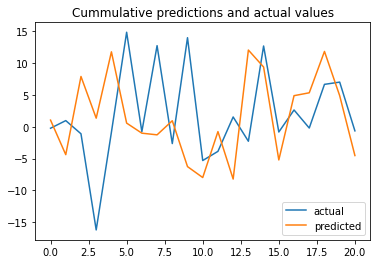

split_date: 2020-09-16 00:00:00
Epoch 1/20
2582/2582 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/20
2582/2582 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/20
2582/2582 - 7s - loss: 0.0189 - 7s/epoch - 3ms/step
Epoch 4/20
2582/2582 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/20
2582/2582 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/20
2582/2582 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/20
2582/2582 - 7s - loss: 0.0177 - 7s/epoch - 3ms/step
Epoch 8/20
2582/2582 - 7s - loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 9/20
2582/2582 - 7s - loss: 0.0171 - 7s/epoch - 3ms/step
Epoch 10/20
2582/2582 - 8s - loss: 0.0168 - 8s/epoch - 3ms/step
Epoch 11/20
2582/2582 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 12/20
2582/2582 - 8s - loss: 0.0163 - 8s/epoch - 3ms/step
Epoch 13/20
2582/2582 - 8s - loss: 0.0161 - 8s/epoch - 3ms/step
Epoch 14/20
2582/2582 - 8s - loss: 0.0159 - 8s/epoch - 3ms/step
Epoch 15/20
2582/2582 - 7s - loss: 0.0158 - 7s/epoch - 3ms/step
Epoch 16/20
2582/

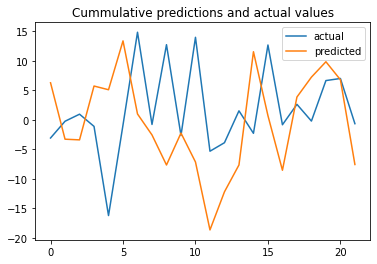

split_date: 2020-09-14 00:00:00
Epoch 1/20
2579/2579 - 9s - loss: 0.0193 - 9s/epoch - 3ms/step
Epoch 2/20
2579/2579 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/20
2579/2579 - 7s - loss: 0.0189 - 7s/epoch - 3ms/step
Epoch 4/20
2579/2579 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/20
2579/2579 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/20
2579/2579 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/20
2579/2579 - 7s - loss: 0.0176 - 7s/epoch - 3ms/step
Epoch 8/20
2579/2579 - 8s - loss: 0.0173 - 8s/epoch - 3ms/step
Epoch 9/20
2579/2579 - 7s - loss: 0.0170 - 7s/epoch - 3ms/step
Epoch 10/20
2579/2579 - 8s - loss: 0.0167 - 8s/epoch - 3ms/step
Epoch 11/20
2579/2579 - 7s - loss: 0.0164 - 7s/epoch - 3ms/step
Epoch 12/20
2579/2579 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step
Epoch 13/20
2579/2579 - 9s - loss: 0.0160 - 9s/epoch - 3ms/step
Epoch 14/20
2579/2579 - 8s - loss: 0.0158 - 8s/epoch - 3ms/step
Epoch 15/20
2579/2579 - 7s - loss: 0.0157 - 7s/epoch - 3ms/step
Epoch 16/20
2579/

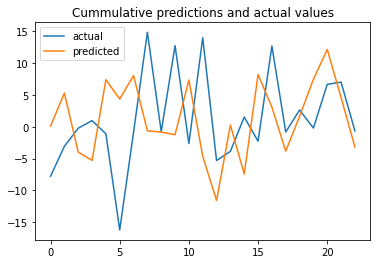

split_date: 2020-09-10 00:00:00
Epoch 1/20
2576/2576 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/20
2576/2576 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/20
2576/2576 - 8s - loss: 0.0189 - 8s/epoch - 3ms/step
Epoch 4/20
2576/2576 - 8s - loss: 0.0187 - 8s/epoch - 3ms/step
Epoch 5/20
2576/2576 - 8s - loss: 0.0183 - 8s/epoch - 3ms/step
Epoch 6/20
2576/2576 - 8s - loss: 0.0180 - 8s/epoch - 3ms/step
Epoch 7/20
2576/2576 - 7s - loss: 0.0177 - 7s/epoch - 3ms/step
Epoch 8/20
2576/2576 - 8s - loss: 0.0174 - 8s/epoch - 3ms/step
Epoch 9/20
2576/2576 - 7s - loss: 0.0171 - 7s/epoch - 3ms/step
Epoch 10/20
2576/2576 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step
Epoch 11/20
2576/2576 - 8s - loss: 0.0166 - 8s/epoch - 3ms/step
Epoch 12/20
2576/2576 - 8s - loss: 0.0163 - 8s/epoch - 3ms/step
Epoch 13/20
2576/2576 - 8s - loss: 0.0162 - 8s/epoch - 3ms/step
Epoch 14/20
2576/2576 - 8s - loss: 0.0159 - 8s/epoch - 3ms/step
Epoch 15/20
2576/2576 - 7s - loss: 0.0158 - 7s/epoch - 3ms/step
Epoch 16/20
2576/

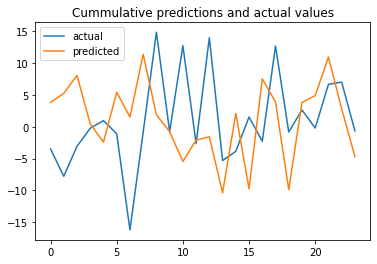

split_date: 2020-09-08 00:00:00
Epoch 1/20
2573/2573 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/20
2573/2573 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/20
2573/2573 - 7s - loss: 0.0189 - 7s/epoch - 3ms/step
Epoch 4/20
2573/2573 - 8s - loss: 0.0186 - 8s/epoch - 3ms/step
Epoch 5/20
2573/2573 - 8s - loss: 0.0183 - 8s/epoch - 3ms/step
Epoch 6/20
2573/2573 - 8s - loss: 0.0180 - 8s/epoch - 3ms/step
Epoch 7/20
2573/2573 - 7s - loss: 0.0176 - 7s/epoch - 3ms/step
Epoch 8/20
2573/2573 - 7s - loss: 0.0173 - 7s/epoch - 3ms/step
Epoch 9/20
2573/2573 - 8s - loss: 0.0170 - 8s/epoch - 3ms/step
Epoch 10/20
2573/2573 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step
Epoch 11/20
2573/2573 - 8s - loss: 0.0165 - 8s/epoch - 3ms/step
Epoch 12/20
2573/2573 - 8s - loss: 0.0163 - 8s/epoch - 3ms/step
Epoch 13/20
2573/2573 - 8s - loss: 0.0161 - 8s/epoch - 3ms/step
Epoch 14/20
2573/2573 - 7s - loss: 0.0160 - 7s/epoch - 3ms/step
Epoch 15/20
2573/2573 - 7s - loss: 0.0158 - 7s/epoch - 3ms/step
Epoch 16/20
2573/

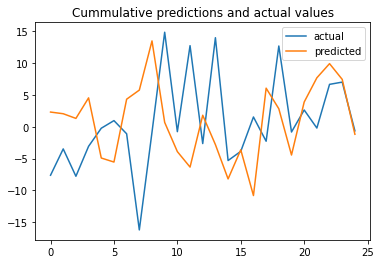

split_date: 2020-09-04 00:00:00
Epoch 1/20
2570/2570 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/20
2570/2570 - 7s - loss: 0.0192 - 7s/epoch - 3ms/step
Epoch 3/20
2570/2570 - 7s - loss: 0.0190 - 7s/epoch - 3ms/step
Epoch 4/20
2570/2570 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/20
2570/2570 - 7s - loss: 0.0184 - 7s/epoch - 3ms/step
Epoch 6/20
2570/2570 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/20
2570/2570 - 8s - loss: 0.0178 - 8s/epoch - 3ms/step
Epoch 8/20
2570/2570 - 7s - loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 9/20
2570/2570 - 7s - loss: 0.0171 - 7s/epoch - 3ms/step
Epoch 10/20
2570/2570 - 8s - loss: 0.0169 - 8s/epoch - 3ms/step
Epoch 11/20
2570/2570 - 8s - loss: 0.0166 - 8s/epoch - 3ms/step
Epoch 12/20
2570/2570 - 8s - loss: 0.0164 - 8s/epoch - 3ms/step
Epoch 13/20
2570/2570 - 8s - loss: 0.0162 - 8s/epoch - 3ms/step
Epoch 14/20
2570/2570 - 8s - loss: 0.0160 - 8s/epoch - 3ms/step
Epoch 15/20
2570/2570 - 8s - loss: 0.0158 - 8s/epoch - 3ms/step
Epoch 16/20
2570/

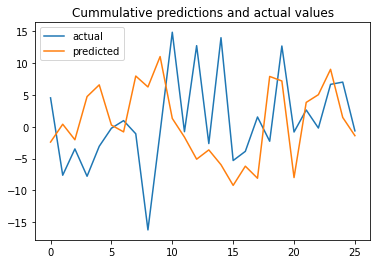

split_date: 2020-09-02 00:00:00
Epoch 1/20
2567/2567 - 10s - loss: 0.0193 - 10s/epoch - 4ms/step
Epoch 2/20
2567/2567 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/20
2567/2567 - 8s - loss: 0.0190 - 8s/epoch - 3ms/step
Epoch 4/20
2567/2567 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/20
2567/2567 - 8s - loss: 0.0183 - 8s/epoch - 3ms/step
Epoch 6/20
2567/2567 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/20
2567/2567 - 8s - loss: 0.0177 - 8s/epoch - 3ms/step
Epoch 8/20
2567/2567 - 8s - loss: 0.0174 - 8s/epoch - 3ms/step
Epoch 9/20
2567/2567 - 8s - loss: 0.0171 - 8s/epoch - 3ms/step
Epoch 10/20
2567/2567 - 7s - loss: 0.0169 - 7s/epoch - 3ms/step
Epoch 11/20
2567/2567 - 8s - loss: 0.0166 - 8s/epoch - 3ms/step
Epoch 12/20
2567/2567 - 8s - loss: 0.0164 - 8s/epoch - 3ms/step
Epoch 13/20
2567/2567 - 8s - loss: 0.0162 - 8s/epoch - 3ms/step
Epoch 14/20
2567/2567 - 7s - loss: 0.0159 - 7s/epoch - 3ms/step
Epoch 15/20
2567/2567 - 8s - loss: 0.0158 - 8s/epoch - 3ms/step
Epoch 16/20
256

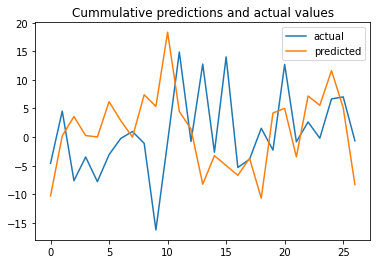

split_date: 2020-08-31 00:00:00
Epoch 1/20
2564/2564 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/20
2564/2564 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/20
2564/2564 - 7s - loss: 0.0189 - 7s/epoch - 3ms/step
Epoch 4/20
2564/2564 - 8s - loss: 0.0186 - 8s/epoch - 3ms/step
Epoch 5/20
2564/2564 - 8s - loss: 0.0183 - 8s/epoch - 3ms/step
Epoch 6/20
2564/2564 - 8s - loss: 0.0180 - 8s/epoch - 3ms/step
Epoch 7/20
2564/2564 - 8s - loss: 0.0177 - 8s/epoch - 3ms/step
Epoch 8/20
2564/2564 - 7s - loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 9/20
2564/2564 - 8s - loss: 0.0171 - 8s/epoch - 3ms/step
Epoch 10/20
2564/2564 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step
Epoch 11/20
2564/2564 - 7s - loss: 0.0165 - 7s/epoch - 3ms/step
Epoch 12/20
2564/2564 - 7s - loss: 0.0163 - 7s/epoch - 3ms/step
Epoch 13/20
2564/2564 - 8s - loss: 0.0161 - 8s/epoch - 3ms/step
Epoch 14/20
2564/2564 - 7s - loss: 0.0159 - 7s/epoch - 3ms/step
Epoch 15/20
2564/2564 - 7s - loss: 0.0158 - 7s/epoch - 3ms/step
Epoch 16/20
2564/

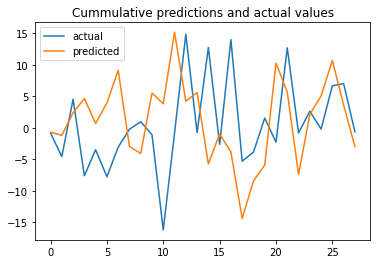

split_date: 2020-08-27 00:00:00
Epoch 1/20
2561/2561 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/20
2561/2561 - 8s - loss: 0.0192 - 8s/epoch - 3ms/step
Epoch 3/20
2561/2561 - 8s - loss: 0.0190 - 8s/epoch - 3ms/step
Epoch 4/20
2561/2561 - 8s - loss: 0.0187 - 8s/epoch - 3ms/step
Epoch 5/20
2561/2561 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/20
2561/2561 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/20
2561/2561 - 8s - loss: 0.0177 - 8s/epoch - 3ms/step
Epoch 8/20
2561/2561 - 8s - loss: 0.0173 - 8s/epoch - 3ms/step
Epoch 9/20
2561/2561 - 8s - loss: 0.0171 - 8s/epoch - 3ms/step
Epoch 10/20
2561/2561 - 8s - loss: 0.0168 - 8s/epoch - 3ms/step
Epoch 11/20
2561/2561 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 12/20
2561/2561 - 8s - loss: 0.0163 - 8s/epoch - 3ms/step
Epoch 13/20
2561/2561 - 8s - loss: 0.0161 - 8s/epoch - 3ms/step
Epoch 14/20
2561/2561 - 7s - loss: 0.0159 - 7s/epoch - 3ms/step
Epoch 15/20
2561/2561 - 8s - loss: 0.0157 - 8s/epoch - 3ms/step
Epoch 16/20
2561/

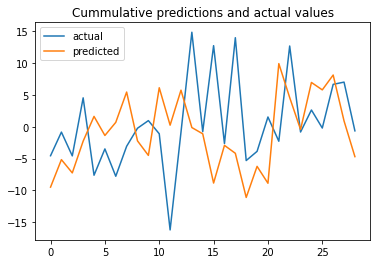

split_date: 2020-08-25 00:00:00
Epoch 1/20
2558/2558 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/20
2558/2558 - 8s - loss: 0.0191 - 8s/epoch - 3ms/step
Epoch 3/20
2558/2558 - 8s - loss: 0.0189 - 8s/epoch - 3ms/step
Epoch 4/20
2558/2558 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/20
2558/2558 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/20
2558/2558 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/20
2558/2558 - 7s - loss: 0.0177 - 7s/epoch - 3ms/step
Epoch 8/20
2558/2558 - 7s - loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 9/20
2558/2558 - 7s - loss: 0.0172 - 7s/epoch - 3ms/step
Epoch 10/20
2558/2558 - 7s - loss: 0.0169 - 7s/epoch - 3ms/step
Epoch 11/20
2558/2558 - 7s - loss: 0.0167 - 7s/epoch - 3ms/step
Epoch 12/20
2558/2558 - 8s - loss: 0.0165 - 8s/epoch - 3ms/step
Epoch 13/20
2558/2558 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step
Epoch 14/20
2558/2558 - 7s - loss: 0.0160 - 7s/epoch - 3ms/step
Epoch 15/20
2558/2558 - 7s - loss: 0.0159 - 7s/epoch - 3ms/step
Epoch 16/20
2558/

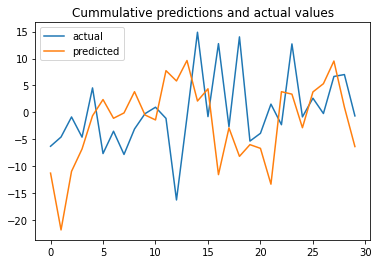

split_date: 2020-08-21 00:00:00
Epoch 1/20
2555/2555 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/20
2555/2555 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/20
2555/2555 - 7s - loss: 0.0190 - 7s/epoch - 3ms/step
Epoch 4/20
2555/2555 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/20
2555/2555 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/20
2555/2555 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/20
2555/2555 - 7s - loss: 0.0176 - 7s/epoch - 3ms/step
Epoch 8/20
2555/2555 - 7s - loss: 0.0175 - 7s/epoch - 3ms/step
Epoch 9/20
2555/2555 - 7s - loss: 0.0172 - 7s/epoch - 3ms/step
Epoch 10/20
2555/2555 - 8s - loss: 0.0168 - 8s/epoch - 3ms/step
Epoch 11/20
2555/2555 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 12/20
2555/2555 - 7s - loss: 0.0163 - 7s/epoch - 3ms/step
Epoch 13/20
2555/2555 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step
Epoch 14/20
2555/2555 - 7s - loss: 0.0160 - 7s/epoch - 3ms/step
Epoch 15/20
2555/2555 - 8s - loss: 0.0158 - 8s/epoch - 3ms/step
Epoch 16/20
2555/

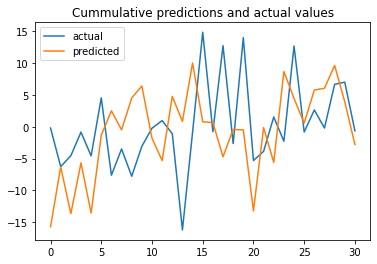

In [39]:
window_dic = {}

for window in window_lst:
    split_date = list(train.index[-(2 * window + 1):])[0]
    print("split_date:", split_date)

    # Split the training and test set
    training_set, test_set = train.loc[train.index < split_date], train.loc[train.index >= split_date]

    # Create windows for training
    LSTM_training_inputs, LSTM_training_outputs = make_train_window(training_set, window)

    # Create windows for testing
    LSTM_test_inputs, LSTM_test_outputs = make_test_window(test_set, window)

    # initialise model architecture
    nn_model = build_model(LSTM_training_inputs, output_size=737, neurons=32)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch

    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                              epochs=20, batch_size=1, verbose=2, shuffle=True)
    
    plt.plot(LSTM_test_outputs.sum(axis=1), label="actual")
    plt.plot(nn_model.predict(LSTM_test_inputs).sum(axis=1), label="predicted")
    plt.legend()
    plt.title("Cummulative predictions and actual values")
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    window_dic[window] = MAE
window_result = pd.DataFrame(window_dic.values(), window_dic.keys()).rename(columns={0: "MAE"})

In [40]:
window_result.sort_values(by="MAE")

MAE
10  0.016398
28  0.016878
12  0.016888
30  0.016954
11  0.016979
27  0.017417
25  0.017541
26  0.017685
23  0.017805
24  0.017817
29  0.017817
13  0.017836
22  0.018063
20  0.018117
15  0.018324
14  0.018493
16  0.018544
19  0.018908
18  0.019099
21  0.019271
17  0.020015

## Grid Search: Epoch

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/10
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 5s - loss: 0.0176 - 5s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step


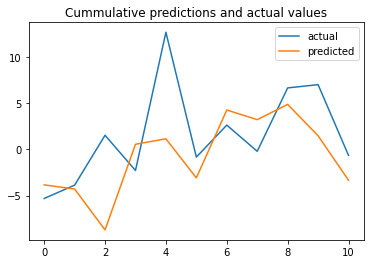

split_date: 2020-10-26 00:00:00
Epoch 1/12
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/12
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/12
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/12
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/12
2615/2615 - 5s - loss: 0.0184 - 5s/epoch - 2ms/step
Epoch 6/12
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/12
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/12
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/12
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/12
2615/2615 - 7s - loss: 0.0169 - 7s/epoch - 3ms/step
Epoch 11/12
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 12/12
2615/2615 - 8s - loss: 0.0163 - 8s/epoch - 3ms/step


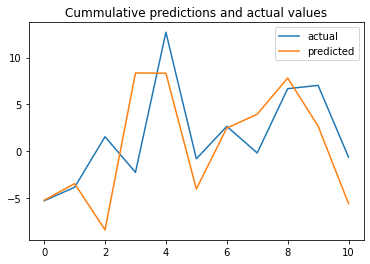

split_date: 2020-10-26 00:00:00
Epoch 1/14
2615/2615 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/14
2615/2615 - 7s - loss: 0.0192 - 7s/epoch - 2ms/step
Epoch 3/14
2615/2615 - 7s - loss: 0.0190 - 7s/epoch - 3ms/step
Epoch 4/14
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/14
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/14
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/14
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/14
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/14
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/14
2615/2615 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step
Epoch 11/14
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/14
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/14
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/14
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step


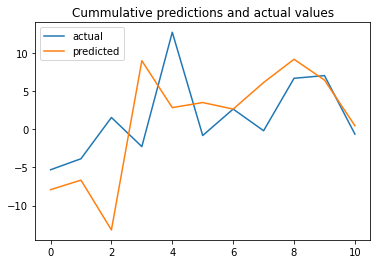

split_date: 2020-10-26 00:00:00
Epoch 1/16
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/16
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/16
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/16
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/16
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/16
2615/2615 - 5s - loss: 0.0181 - 5s/epoch - 2ms/step
Epoch 7/16
2615/2615 - 5s - loss: 0.0178 - 5s/epoch - 2ms/step
Epoch 8/16
2615/2615 - 5s - loss: 0.0175 - 5s/epoch - 2ms/step
Epoch 9/16
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/16
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/16
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/16
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/16
2615/2615 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step
Epoch 14/16
2615/2615 - 7s - loss: 0.0160 - 7s/epoch - 3ms/step
Epoch 15/16
2615/2615 - 7s - loss: 0.0158 - 7s/epoch - 3ms/step
Epoch 16/16
2615/

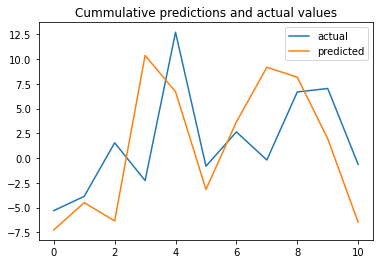

split_date: 2020-10-26 00:00:00
Epoch 1/18
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/18
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/18
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/18
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/18
2615/2615 - 5s - loss: 0.0184 - 5s/epoch - 2ms/step
Epoch 6/18
2615/2615 - 6s - loss: 0.0181 - 6s/epoch - 2ms/step
Epoch 7/18
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 8/18
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 9/18
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/18
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/18
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 12/18
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/18
2615/2615 - 7s - loss: 0.0162 - 7s/epoch - 2ms/step
Epoch 14/18
2615/2615 - 7s - loss: 0.0161 - 7s/epoch - 3ms/step
Epoch 15/18
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 16/18
2615/

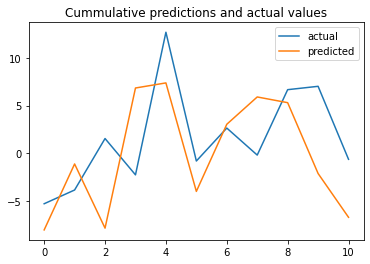

split_date: 2020-10-26 00:00:00
Epoch 1/20
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/20
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/20
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/20
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/20
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/20
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/20
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/20
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/20
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/20
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/20
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 12/20
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/20
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 14/20
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/20
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Epoch 16/20
2615/

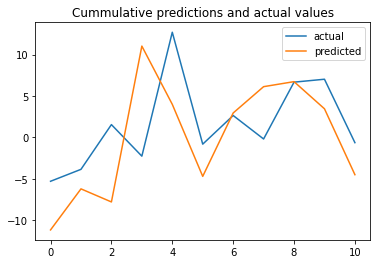

split_date: 2020-10-26 00:00:00
Epoch 1/22
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/22
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/22
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/22
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/22
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/22
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/22
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/22
2615/2615 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 9/22
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/22
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/22
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 12/22
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/22
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/22
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/22
2615/2615 - 6s - loss: 0.0157 - 6s/epoch - 2ms/step
Epoch 16/22
2615/

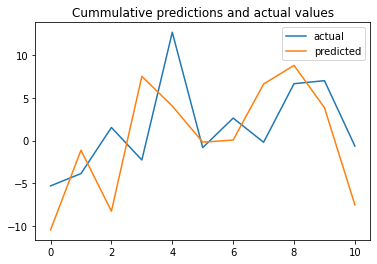

split_date: 2020-10-26 00:00:00
Epoch 1/24
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/24
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/24
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/24
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/24
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/24
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/24
2615/2615 - 5s - loss: 0.0176 - 5s/epoch - 2ms/step
Epoch 8/24
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/24
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/24
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/24
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/24
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/24
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/24
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/24
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/24
2615/

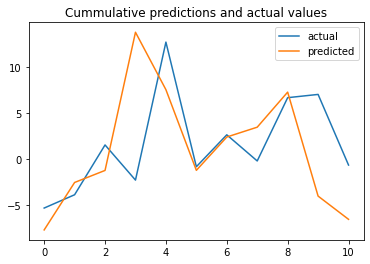

split_date: 2020-10-26 00:00:00
Epoch 1/26
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/26
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/26
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/26
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/26
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/26
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/26
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/26
2615/2615 - 5s - loss: 0.0175 - 5s/epoch - 2ms/step
Epoch 9/26
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/26
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 11/26
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/26
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/26
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/26
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/26
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 16/26
2615/

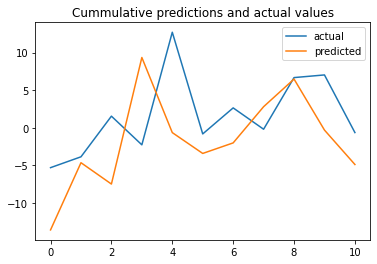

split_date: 2020-10-26 00:00:00
Epoch 1/28
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/28
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/28
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/28
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/28
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/28
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/28
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/28
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/28
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/28
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/28
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/28
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/28
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/28
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/28
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Epoch 16/28
2615/

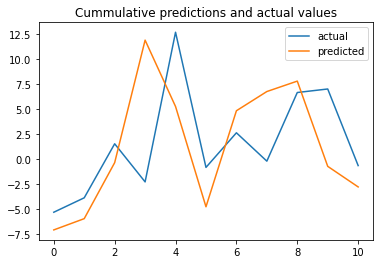

split_date: 2020-10-26 00:00:00
Epoch 1/30
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/30
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/30
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/30
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/30
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/30
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/30
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 8/30
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/30
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/30
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/30
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/30
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/30
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 14/30
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/30
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Epoch 16/30
2615/

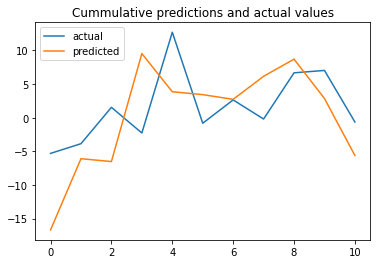

split_date: 2020-10-26 00:00:00
Epoch 1/32
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/32
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/32
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/32
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/32
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/32
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/32
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/32
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/32
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/32
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/32
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/32
2615/2615 - 7s - loss: 0.0163 - 7s/epoch - 3ms/step
Epoch 13/32
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/32
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/32
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Epoch 16/32
2615/

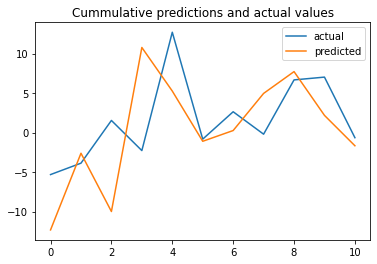

split_date: 2020-10-26 00:00:00
Epoch 1/34
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/34
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/34
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/34
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/34
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/34
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/34
2615/2615 - 5s - loss: 0.0175 - 5s/epoch - 2ms/step
Epoch 8/34
2615/2615 - 5s - loss: 0.0173 - 5s/epoch - 2ms/step
Epoch 9/34
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/34
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 11/34
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 12/34
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/34
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/34
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/34
2615/2615 - 5s - loss: 0.0157 - 5s/epoch - 2ms/step
Epoch 16/34
2615/

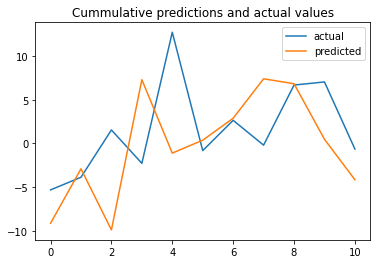

split_date: 2020-10-26 00:00:00
Epoch 1/36
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/36
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/36
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/36
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/36
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/36
2615/2615 - 5s - loss: 0.0181 - 5s/epoch - 2ms/step
Epoch 7/36
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/36
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/36
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/36
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/36
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/36
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/36
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 14/36
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/36
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/36
2615/

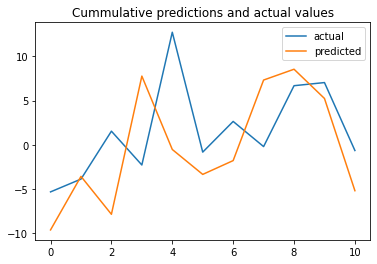

split_date: 2020-10-26 00:00:00
Epoch 1/38
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/38
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/38
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/38
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/38
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/38
2615/2615 - 5s - loss: 0.0181 - 5s/epoch - 2ms/step
Epoch 7/38
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/38
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/38
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/38
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 11/38
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 12/38
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/38
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 14/38
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/38
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/38
2615/

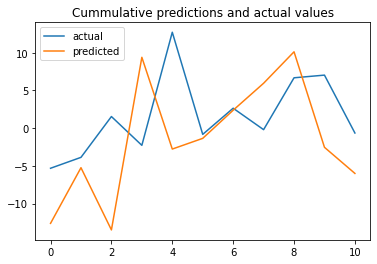

split_date: 2020-10-26 00:00:00
Epoch 1/40
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/40
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/40
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/40
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/40
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/40
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/40
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/40
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/40
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/40
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 11/40
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/40
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 13/40
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/40
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/40
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/40
2615/

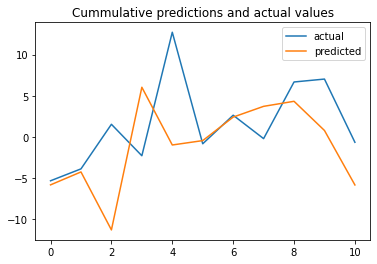

split_date: 2020-10-26 00:00:00
Epoch 1/42
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/42
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/42
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/42
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/42
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/42
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/42
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/42
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/42
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/42
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 11/42
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/42
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/42
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/42
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/42
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/42
2615/

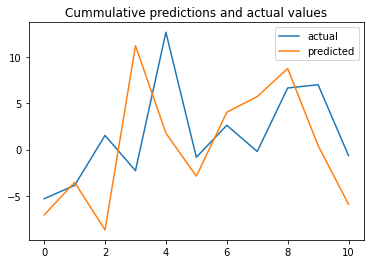

split_date: 2020-10-26 00:00:00
Epoch 1/44
2615/2615 - 9s - loss: 0.0193 - 9s/epoch - 3ms/step
Epoch 2/44
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/44
2615/2615 - 7s - loss: 0.0189 - 7s/epoch - 3ms/step
Epoch 4/44
2615/2615 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/44
2615/2615 - 7s - loss: 0.0182 - 7s/epoch - 3ms/step
Epoch 6/44
2615/2615 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/44
2615/2615 - 7s - loss: 0.0177 - 7s/epoch - 3ms/step
Epoch 8/44
2615/2615 - 7s - loss: 0.0173 - 7s/epoch - 3ms/step
Epoch 9/44
2615/2615 - 7s - loss: 0.0170 - 7s/epoch - 3ms/step
Epoch 10/44
2615/2615 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step
Epoch 11/44
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 12/44
2615/2615 - 7s - loss: 0.0164 - 7s/epoch - 3ms/step
Epoch 13/44
2615/2615 - 7s - loss: 0.0161 - 7s/epoch - 3ms/step
Epoch 14/44
2615/2615 - 7s - loss: 0.0160 - 7s/epoch - 3ms/step
Epoch 15/44
2615/2615 - 7s - loss: 0.0158 - 7s/epoch - 3ms/step
Epoch 16/44
2615/

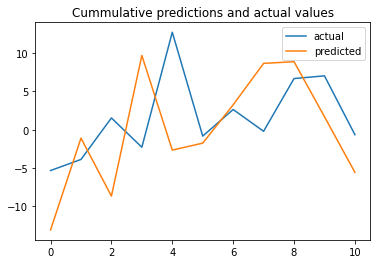

split_date: 2020-10-26 00:00:00
Epoch 1/46
2615/2615 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/46
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/46
2615/2615 - 8s - loss: 0.0189 - 8s/epoch - 3ms/step
Epoch 4/46
2615/2615 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/46
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/46
2615/2615 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/46
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/46
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/46
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/46
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 11/46
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/46
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/46
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/46
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/46
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/46
2615/

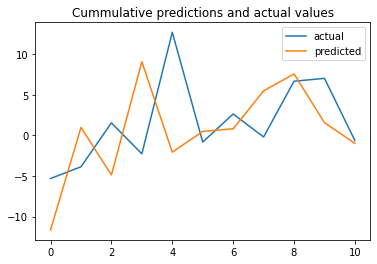

split_date: 2020-10-26 00:00:00
Epoch 1/48
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/48
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/48
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/48
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/48
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/48
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/48
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/48
2615/2615 - 5s - loss: 0.0173 - 5s/epoch - 2ms/step
Epoch 9/48
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/48
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/48
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/48
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/48
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/48
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/48
2615/2615 - 7s - loss: 0.0157 - 7s/epoch - 3ms/step
Epoch 16/48
2615/

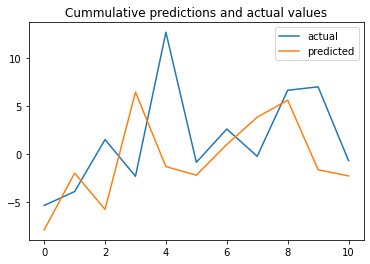

split_date: 2020-10-26 00:00:00
Epoch 1/50
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/50
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/50
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/50
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/50
2615/2615 - 5s - loss: 0.0184 - 5s/epoch - 2ms/step
Epoch 6/50
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/50
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/50
2615/2615 - 5s - loss: 0.0173 - 5s/epoch - 2ms/step
Epoch 9/50
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 10/50
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 11/50
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/50
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 13/50
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 14/50
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 15/50
2615/2615 - 5s - loss: 0.0157 - 5s/epoch - 2ms/step
Epoch 16/50
2615/

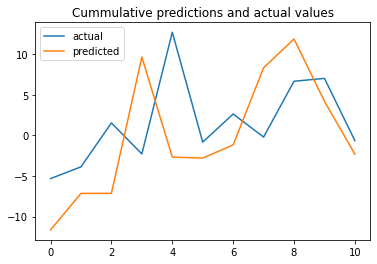

split_date: 2020-10-26 00:00:00
Epoch 1/52
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/52
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/52
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/52
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/52
2615/2615 - 5s - loss: 0.0182 - 5s/epoch - 2ms/step
Epoch 6/52
2615/2615 - 5s - loss: 0.0178 - 5s/epoch - 2ms/step
Epoch 7/52
2615/2615 - 5s - loss: 0.0175 - 5s/epoch - 2ms/step
Epoch 8/52
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 9/52
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/52
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 11/52
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 12/52
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 13/52
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 14/52
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/52
2615/2615 - 5s - loss: 0.0156 - 5s/epoch - 2ms/step
Epoch 16/52
2615/

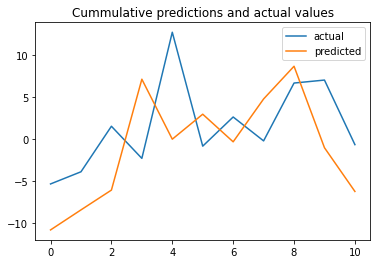

split_date: 2020-10-26 00:00:00
Epoch 1/54
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/54
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/54
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/54
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/54
2615/2615 - 5s - loss: 0.0184 - 5s/epoch - 2ms/step
Epoch 6/54
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/54
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/54
2615/2615 - 5s - loss: 0.0175 - 5s/epoch - 2ms/step
Epoch 9/54
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/54
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 11/54
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 12/54
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/54
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 14/54
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 15/54
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 16/54
2615/

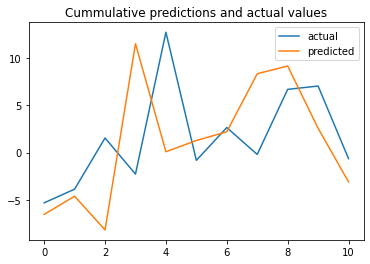

split_date: 2020-10-26 00:00:00
Epoch 1/56
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/56
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/56
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/56
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/56
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/56
2615/2615 - 5s - loss: 0.0181 - 5s/epoch - 2ms/step
Epoch 7/56
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/56
2615/2615 - 5s - loss: 0.0173 - 5s/epoch - 2ms/step
Epoch 9/56
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/56
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/56
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/56
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/56
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/56
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/56
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/56
2615/

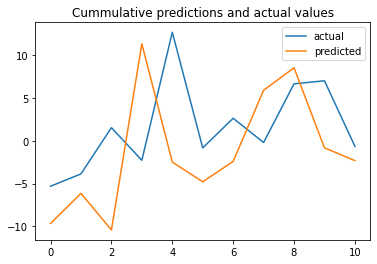

split_date: 2020-10-26 00:00:00
Epoch 1/58
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 2/58
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/58
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/58
2615/2615 - 5s - loss: 0.0188 - 5s/epoch - 2ms/step
Epoch 5/58
2615/2615 - 5s - loss: 0.0184 - 5s/epoch - 2ms/step
Epoch 6/58
2615/2615 - 5s - loss: 0.0181 - 5s/epoch - 2ms/step
Epoch 7/58
2615/2615 - 5s - loss: 0.0178 - 5s/epoch - 2ms/step
Epoch 8/58
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/58
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/58
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 11/58
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 12/58
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 13/58
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 14/58
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 15/58
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 16/58
2615/

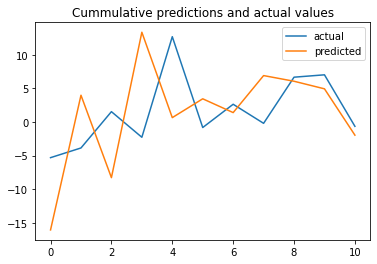

split_date: 2020-10-26 00:00:00
Epoch 1/60
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/60
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/60
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/60
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/60
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/60
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/60
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/60
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/60
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/60
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/60
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/60
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/60
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 14/60
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/60
2615/2615 - 5s - loss: 0.0157 - 5s/epoch - 2ms/step
Epoch 16/60
2615/

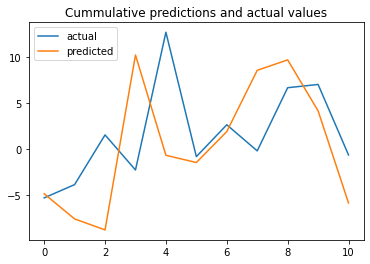

split_date: 2020-10-26 00:00:00
Epoch 1/62
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/62
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/62
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/62
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/62
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/62
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/62
2615/2615 - 5s - loss: 0.0176 - 5s/epoch - 2ms/step
Epoch 8/62
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/62
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/62
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/62
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/62
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 13/62
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/62
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/62
2615/2615 - 5s - loss: 0.0157 - 5s/epoch - 2ms/step
Epoch 16/62
2615/

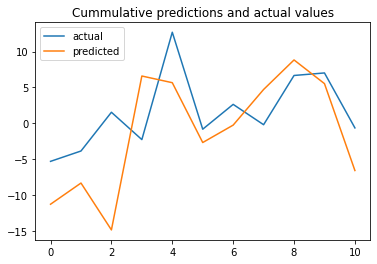

split_date: 2020-10-26 00:00:00
Epoch 1/64
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 2/64
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/64
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/64
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/64
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/64
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/64
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/64
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/64
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/64
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/64
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/64
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/64
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/64
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/64
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/64
2615/

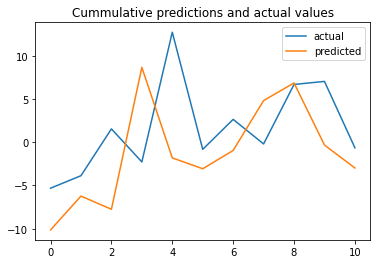

split_date: 2020-10-26 00:00:00
Epoch 1/66
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/66
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/66
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/66
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/66
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/66
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/66
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/66
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/66
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/66
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/66
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/66
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/66
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/66
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/66
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/66
2615/

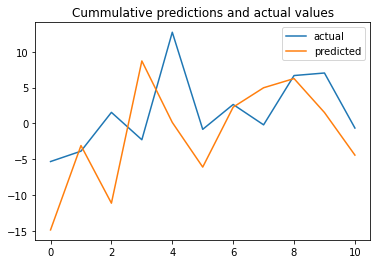

split_date: 2020-10-26 00:00:00
Epoch 1/68
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/68
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/68
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/68
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/68
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/68
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/68
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/68
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/68
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/68
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/68
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/68
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/68
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 14/68
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/68
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/68
2615/

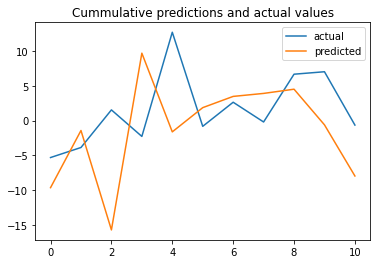

split_date: 2020-10-26 00:00:00
Epoch 1/70
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/70
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/70
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/70
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/70
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/70
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/70
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/70
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/70
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/70
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 11/70
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/70
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 13/70
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/70
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/70
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/70
2615/

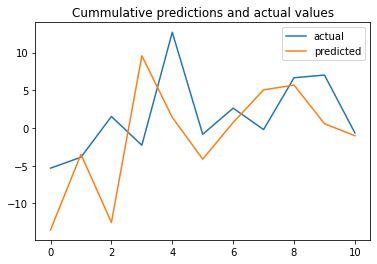

split_date: 2020-10-26 00:00:00
Epoch 1/72
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 2/72
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/72
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/72
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/72
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/72
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/72
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/72
2615/2615 - 5s - loss: 0.0173 - 5s/epoch - 2ms/step
Epoch 9/72
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/72
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/72
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/72
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 13/72
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 14/72
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 15/72
2615/2615 - 5s - loss: 0.0156 - 5s/epoch - 2ms/step
Epoch 16/72
2615/

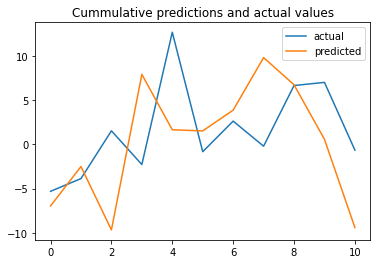

split_date: 2020-10-26 00:00:00
Epoch 1/74
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/74
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/74
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/74
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/74
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/74
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/74
2615/2615 - 5s - loss: 0.0176 - 5s/epoch - 2ms/step
Epoch 8/74
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/74
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/74
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/74
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/74
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/74
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 14/74
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/74
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/74
2615/

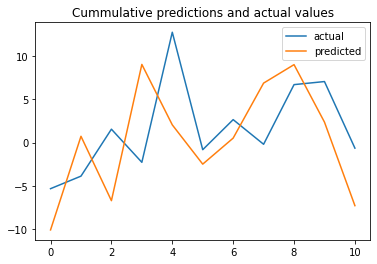

split_date: 2020-10-26 00:00:00
Epoch 1/76
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 2/76
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/76
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/76
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/76
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/76
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/76
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/76
2615/2615 - 5s - loss: 0.0175 - 5s/epoch - 2ms/step
Epoch 9/76
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/76
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 11/76
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/76
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/76
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/76
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/76
2615/2615 - 5s - loss: 0.0157 - 5s/epoch - 2ms/step
Epoch 16/76
2615/

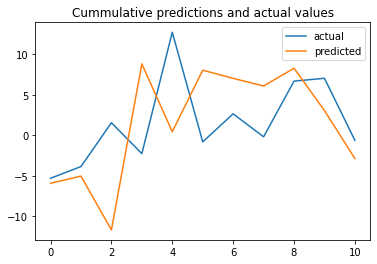

split_date: 2020-10-26 00:00:00
Epoch 1/78
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 2/78
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/78
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/78
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/78
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/78
2615/2615 - 6s - loss: 0.0181 - 6s/epoch - 2ms/step
Epoch 7/78
2615/2615 - 5s - loss: 0.0178 - 5s/epoch - 2ms/step
Epoch 8/78
2615/2615 - 5s - loss: 0.0175 - 5s/epoch - 2ms/step
Epoch 9/78
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/78
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 11/78
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 12/78
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 13/78
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 14/78
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 15/78
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 16/78
2615/

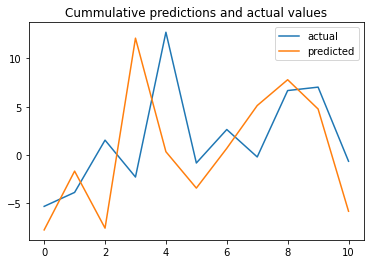

split_date: 2020-10-26 00:00:00
Epoch 1/80
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/80
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/80
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/80
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/80
2615/2615 - 5s - loss: 0.0184 - 5s/epoch - 2ms/step
Epoch 6/80
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/80
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/80
2615/2615 - 5s - loss: 0.0175 - 5s/epoch - 2ms/step
Epoch 9/80
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/80
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 11/80
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/80
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/80
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 14/80
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/80
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/80
2615/

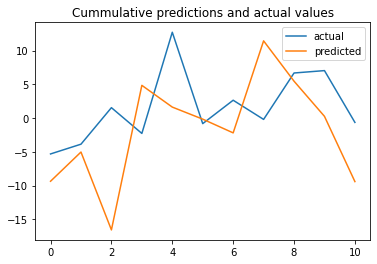

split_date: 2020-10-26 00:00:00
Epoch 1/82
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/82
2615/2615 - 5s - loss: 0.0192 - 5s/epoch - 2ms/step
Epoch 3/82
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/82
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/82
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/82
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/82
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/82
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/82
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/82
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/82
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/82
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/82
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 14/82
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/82
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 16/82
2615/

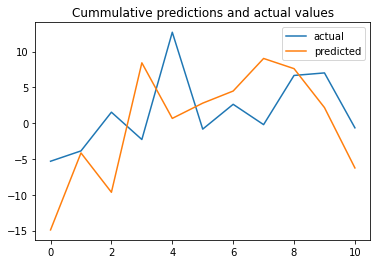

split_date: 2020-10-26 00:00:00
Epoch 1/84
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/84
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/84
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/84
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/84
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/84
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/84
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/84
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/84
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/84
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/84
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/84
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/84
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/84
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/84
2615/2615 - 5s - loss: 0.0157 - 5s/epoch - 2ms/step
Epoch 16/84
2615/

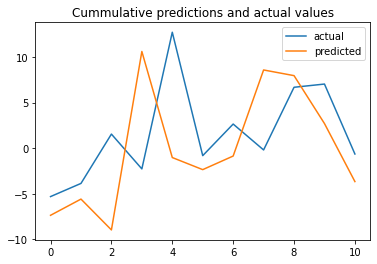

split_date: 2020-10-26 00:00:00
Epoch 1/86
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/86
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/86
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/86
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/86
2615/2615 - 5s - loss: 0.0184 - 5s/epoch - 2ms/step
Epoch 6/86
2615/2615 - 5s - loss: 0.0181 - 5s/epoch - 2ms/step
Epoch 7/86
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/86
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/86
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/86
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/86
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/86
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/86
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/86
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/86
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/86
2615/

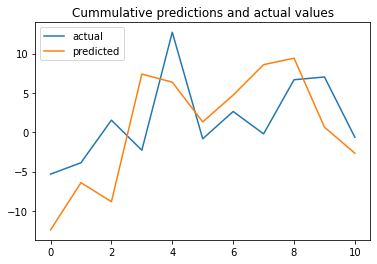

split_date: 2020-10-26 00:00:00
Epoch 1/88
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 2/88
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/88
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/88
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/88
2615/2615 - 5s - loss: 0.0182 - 5s/epoch - 2ms/step
Epoch 6/88
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/88
2615/2615 - 5s - loss: 0.0176 - 5s/epoch - 2ms/step
Epoch 8/88
2615/2615 - 5s - loss: 0.0173 - 5s/epoch - 2ms/step
Epoch 9/88
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/88
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/88
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/88
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/88
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 14/88
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/88
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/88
2615/

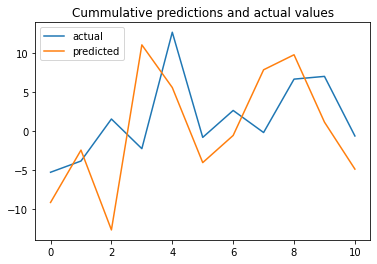

split_date: 2020-10-26 00:00:00
Epoch 1/90
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/90
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/90
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/90
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/90
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/90
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/90
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/90
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/90
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/90
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/90
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/90
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/90
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/90
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 15/90
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/90
2615/

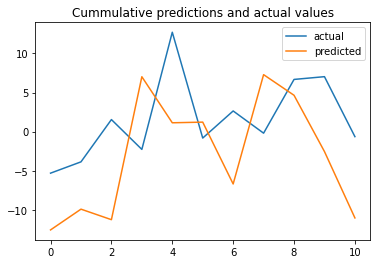

split_date: 2020-10-26 00:00:00
Epoch 1/92
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 2/92
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/92
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/92
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/92
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/92
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/92
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/92
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/92
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/92
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 11/92
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/92
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/92
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/92
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/92
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/92
2615/

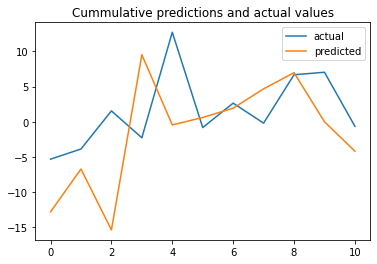

split_date: 2020-10-26 00:00:00
Epoch 1/94
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/94
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/94
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/94
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/94
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/94
2615/2615 - 5s - loss: 0.0181 - 5s/epoch - 2ms/step
Epoch 7/94
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/94
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/94
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/94
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/94
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/94
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/94
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/94
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 15/94
2615/2615 - 5s - loss: 0.0157 - 5s/epoch - 2ms/step
Epoch 16/94
2615/

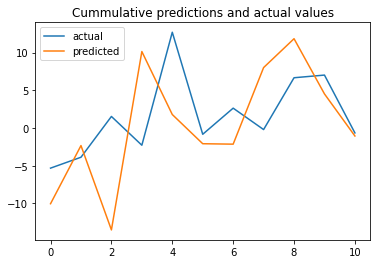

split_date: 2020-10-26 00:00:00
Epoch 1/96
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/96
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/96
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/96
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/96
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/96
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/96
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/96
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/96
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/96
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 11/96
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/96
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/96
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 14/96
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 15/96
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 16/96
2615/

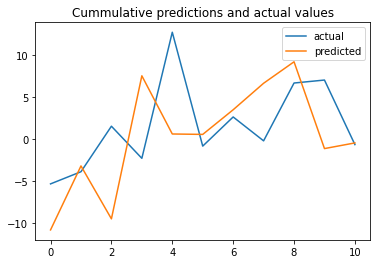

split_date: 2020-10-26 00:00:00
Epoch 1/98
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/98
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/98
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/98
2615/2615 - 5s - loss: 0.0185 - 5s/epoch - 2ms/step
Epoch 5/98
2615/2615 - 5s - loss: 0.0182 - 5s/epoch - 2ms/step
Epoch 6/98
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/98
2615/2615 - 5s - loss: 0.0176 - 5s/epoch - 2ms/step
Epoch 8/98
2615/2615 - 5s - loss: 0.0173 - 5s/epoch - 2ms/step
Epoch 9/98
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/98
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 11/98
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/98
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/98
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/98
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/98
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Epoch 16/98
2615/

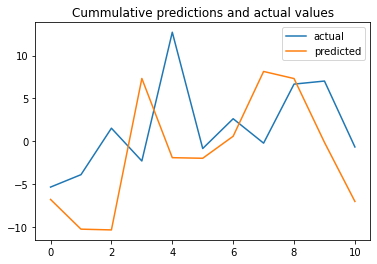

split_date: 2020-10-26 00:00:00
Epoch 1/100
2615/2615 - 7s - loss: 0.0192 - 7s/epoch - 3ms/step
Epoch 2/100
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/100
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/100
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/100
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/100
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/100
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/100
2615/2615 - 7s - loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 9/100
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/100
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/100
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/100
2615/2615 - 7s - loss: 0.0163 - 7s/epoch - 3ms/step
Epoch 13/100
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/100
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Epoch 15/100
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

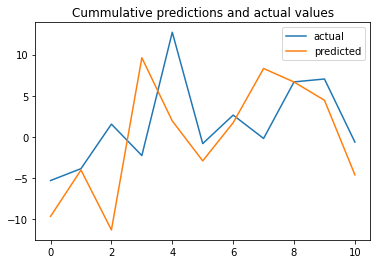

split_date: 2020-10-26 00:00:00
Epoch 1/102
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/102
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/102
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/102
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/102
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/102
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/102
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/102
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/102
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/102
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/102
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/102
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/102
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/102
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/102
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Ep

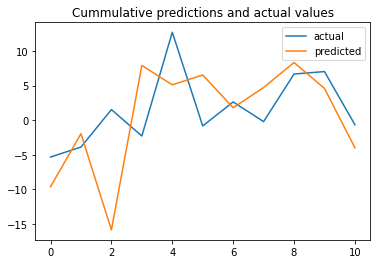

split_date: 2020-10-26 00:00:00
Epoch 1/104
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/104
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/104
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/104
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/104
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/104
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/104
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/104
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/104
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/104
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 11/104
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/104
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/104
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 14/104
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/104
2615/2615 - 6s - loss: 0.0157 - 6s/epoch - 2ms/step
Ep

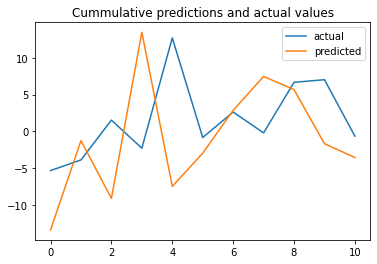

split_date: 2020-10-26 00:00:00
Epoch 1/106
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/106
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/106
2615/2615 - 7s - loss: 0.0189 - 7s/epoch - 3ms/step
Epoch 4/106
2615/2615 - 8s - loss: 0.0186 - 8s/epoch - 3ms/step
Epoch 5/106
2615/2615 - 8s - loss: 0.0183 - 8s/epoch - 3ms/step
Epoch 6/106
2615/2615 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/106
2615/2615 - 7s - loss: 0.0177 - 7s/epoch - 3ms/step
Epoch 8/106
2615/2615 - 8s - loss: 0.0173 - 8s/epoch - 3ms/step
Epoch 9/106
2615/2615 - 8s - loss: 0.0170 - 8s/epoch - 3ms/step
Epoch 10/106
2615/2615 - 7s - loss: 0.0167 - 7s/epoch - 3ms/step
Epoch 11/106
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 12/106
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/106
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 14/106
2615/2615 - 8s - loss: 0.0158 - 8s/epoch - 3ms/step
Epoch 15/106
2615/2615 - 8s - loss: 0.0157 - 8s/epoch - 3ms/step
Ep

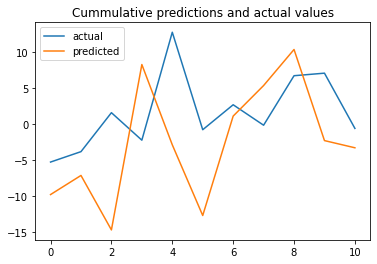

split_date: 2020-10-26 00:00:00
Epoch 1/108
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 2/108
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/108
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/108
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/108
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/108
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/108
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/108
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/108
2615/2615 - 7s - loss: 0.0171 - 7s/epoch - 3ms/step
Epoch 10/108
2615/2615 - 7s - loss: 0.0169 - 7s/epoch - 3ms/step
Epoch 11/108
2615/2615 - 8s - loss: 0.0166 - 8s/epoch - 3ms/step
Epoch 12/108
2615/2615 - 8s - loss: 0.0164 - 8s/epoch - 3ms/step
Epoch 13/108
2615/2615 - 8s - loss: 0.0162 - 8s/epoch - 3ms/step
Epoch 14/108
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/108
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

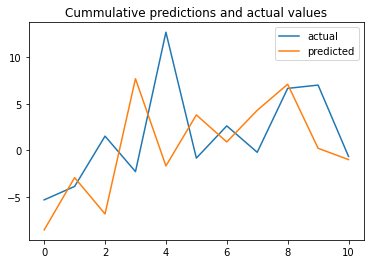

split_date: 2020-10-26 00:00:00
Epoch 1/110
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/110
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/110
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/110
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/110
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/110
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/110
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/110
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 9/110
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 10/110
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 11/110
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 12/110
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 13/110
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 14/110
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/110
2615/2615 - 6s - loss: 0.0157 - 6s/epoch - 2ms/step
Ep

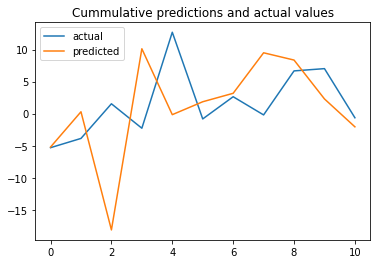

split_date: 2020-10-26 00:00:00
Epoch 1/112
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/112
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/112
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/112
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/112
2615/2615 - 5s - loss: 0.0182 - 5s/epoch - 2ms/step
Epoch 6/112
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/112
2615/2615 - 5s - loss: 0.0176 - 5s/epoch - 2ms/step
Epoch 8/112
2615/2615 - 5s - loss: 0.0173 - 5s/epoch - 2ms/step
Epoch 9/112
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/112
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 11/112
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/112
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/112
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/112
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/112
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Ep

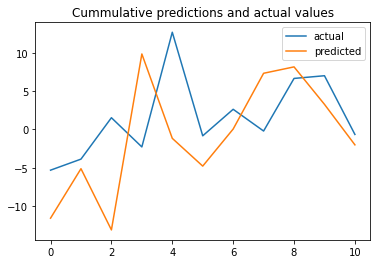

split_date: 2020-10-26 00:00:00
Epoch 1/114
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/114
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/114
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/114
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/114
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/114
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/114
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 8/114
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/114
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/114
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/114
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/114
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/114
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/114
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/114
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Ep

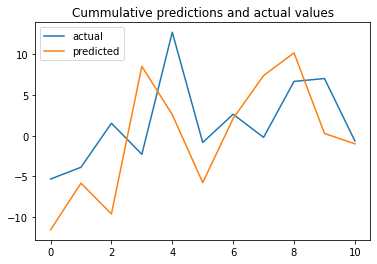

split_date: 2020-10-26 00:00:00
Epoch 1/116
2615/2615 - 7s - loss: 0.0192 - 7s/epoch - 2ms/step
Epoch 2/116
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/116
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/116
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/116
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/116
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/116
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/116
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/116
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/116
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/116
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/116
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/116
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/116
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/116
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

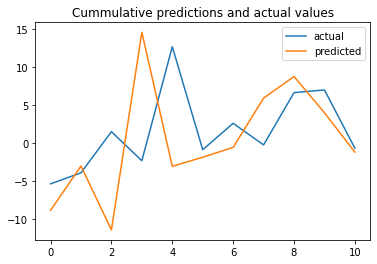

split_date: 2020-10-26 00:00:00
Epoch 1/118
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/118
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/118
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/118
2615/2615 - 8s - loss: 0.0187 - 8s/epoch - 3ms/step
Epoch 5/118
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/118
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/118
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/118
2615/2615 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 9/118
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/118
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/118
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 12/118
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/118
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/118
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/118
2615/2615 - 7s - loss: 0.0157 - 7s/epoch - 3ms/step
Ep

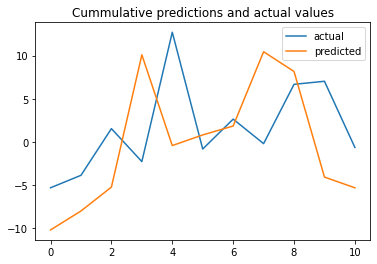

split_date: 2020-10-26 00:00:00
Epoch 1/120
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 2ms/step
Epoch 2/120
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/120
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/120
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/120
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/120
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/120
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/120
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/120
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/120
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/120
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 12/120
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/120
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/120
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/120
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

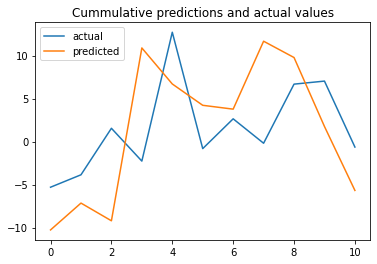

split_date: 2020-10-26 00:00:00
Epoch 1/122
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/122
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/122
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/122
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/122
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/122
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/122
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/122
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/122
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/122
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/122
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/122
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 13/122
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 14/122
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/122
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Ep

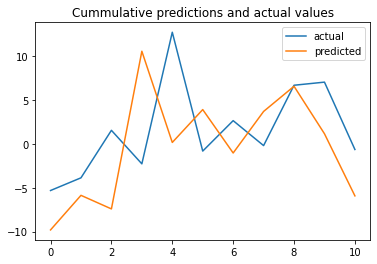

split_date: 2020-10-26 00:00:00
Epoch 1/124
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/124
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/124
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/124
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/124
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/124
2615/2615 - 6s - loss: 0.0181 - 6s/epoch - 2ms/step
Epoch 7/124
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/124
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/124
2615/2615 - 7s - loss: 0.0172 - 7s/epoch - 3ms/step
Epoch 10/124
2615/2615 - 7s - loss: 0.0169 - 7s/epoch - 3ms/step
Epoch 11/124
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/124
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/124
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/124
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/124
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

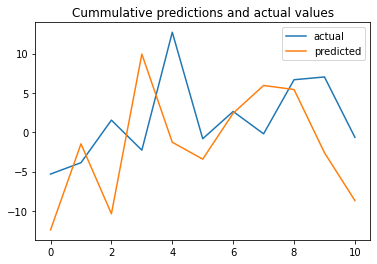

split_date: 2020-10-26 00:00:00
Epoch 1/126
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/126
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/126
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/126
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/126
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/126
2615/2615 - 6s - loss: 0.0181 - 6s/epoch - 2ms/step
Epoch 7/126
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 8/126
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 9/126
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/126
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 11/126
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/126
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/126
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/126
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/126
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

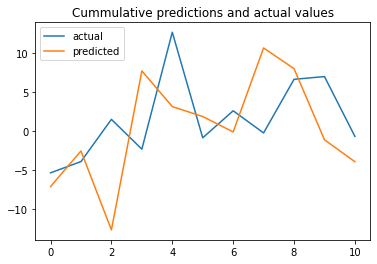

split_date: 2020-10-26 00:00:00
Epoch 1/128
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/128
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/128
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/128
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/128
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/128
2615/2615 - 6s - loss: 0.0181 - 6s/epoch - 2ms/step
Epoch 7/128
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/128
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/128
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/128
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/128
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/128
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/128
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/128
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/128
2615/2615 - 7s - loss: 0.0158 - 7s/epoch - 3ms/step
Ep

Epoch 127/128
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 128/128
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step


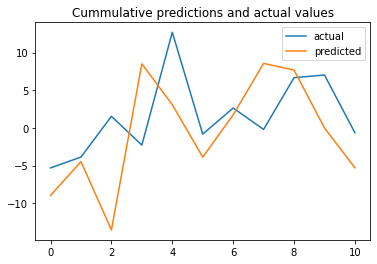

split_date: 2020-10-26 00:00:00
Epoch 1/130
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/130
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/130
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/130
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/130
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/130
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/130
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/130
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/130
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/130
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/130
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/130
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 13/130
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/130
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/130
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

Epoch 127/130
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 128/130
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 129/130
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 130/130
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step


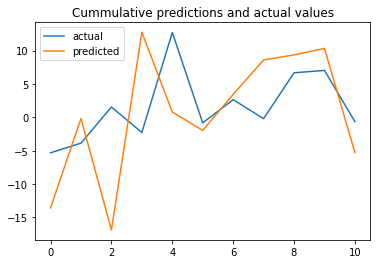

split_date: 2020-10-26 00:00:00
Epoch 1/132
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/132
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/132
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/132
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/132
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/132
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/132
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/132
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 9/132
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/132
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/132
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/132
2615/2615 - 7s - loss: 0.0163 - 7s/epoch - 3ms/step
Epoch 13/132
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/132
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/132
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

Epoch 127/132
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 128/132
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 129/132
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 130/132
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 131/132
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 132/132
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step


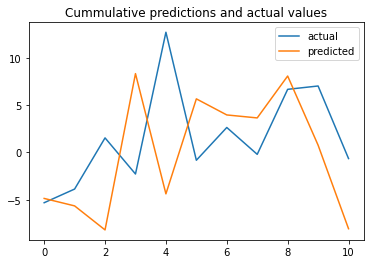

split_date: 2020-10-26 00:00:00
Epoch 1/134
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 2ms/step
Epoch 2/134
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/134
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/134
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/134
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/134
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/134
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/134
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 9/134
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/134
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 11/134
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/134
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/134
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/134
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/134
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

Epoch 127/134
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 128/134
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 129/134
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 130/134
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 131/134
2615/2615 - 7s - loss: 0.0141 - 7s/epoch - 3ms/step
Epoch 132/134
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 133/134
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 134/134
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step


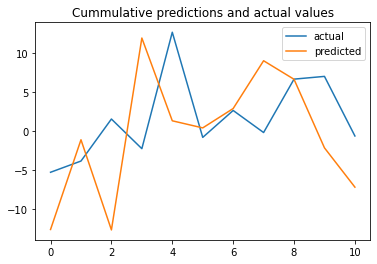

split_date: 2020-10-26 00:00:00
Epoch 1/136
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/136
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/136
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/136
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/136
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/136
2615/2615 - 6s - loss: 0.0181 - 6s/epoch - 2ms/step
Epoch 7/136
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 8/136
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 9/136
2615/2615 - 7s - loss: 0.0172 - 7s/epoch - 3ms/step
Epoch 10/136
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/136
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/136
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/136
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/136
2615/2615 - 7s - loss: 0.0160 - 7s/epoch - 3ms/step
Epoch 15/136
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

Epoch 127/136
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 128/136
2615/2615 - 7s - loss: 0.0141 - 7s/epoch - 3ms/step
Epoch 129/136
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 130/136
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 131/136
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 132/136
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 133/136
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 134/136
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 135/136
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 136/136
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step


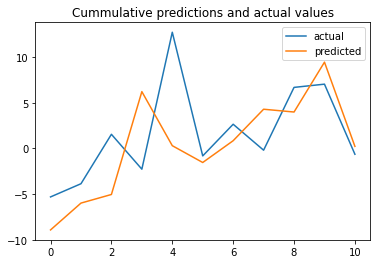

split_date: 2020-10-26 00:00:00
Epoch 1/138
2615/2615 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/138
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/138
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/138
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/138
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/138
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/138
2615/2615 - 7s - loss: 0.0178 - 7s/epoch - 3ms/step
Epoch 8/138
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/138
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/138
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/138
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 12/138
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 13/138
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/138
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/138
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Ep

Epoch 127/138
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 128/138
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 129/138
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 130/138
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 131/138
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 132/138
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 133/138
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 134/138
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 135/138
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 136/138
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 137/138
2615/2615 - 7s - loss: 0.0140 - 7s/epoch - 3ms/step
Epoch 138/138
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step


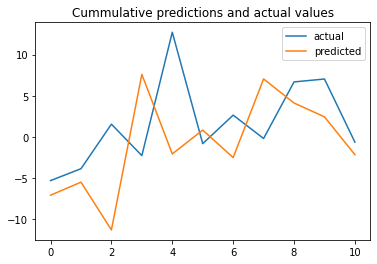

split_date: 2020-10-26 00:00:00
Epoch 1/140
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 2ms/step
Epoch 2/140
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/140
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/140
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/140
2615/2615 - 5s - loss: 0.0184 - 5s/epoch - 2ms/step
Epoch 6/140
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/140
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 8/140
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/140
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/140
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/140
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 12/140
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/140
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 14/140
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/140
2615/2615 - 6s - loss: 0.0157 - 6s/epoch - 2ms/step
Ep

Epoch 127/140
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 128/140
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 129/140
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 130/140
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 131/140
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 132/140
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 133/140
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 134/140
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 135/140
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 136/140
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 137/140
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 138/140
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 139/140
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 140/140
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step


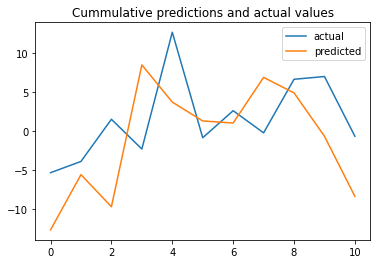

split_date: 2020-10-26 00:00:00
Epoch 1/142
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/142
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/142
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/142
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/142
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/142
2615/2615 - 5s - loss: 0.0181 - 5s/epoch - 2ms/step
Epoch 7/142
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/142
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/142
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/142
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/142
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/142
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/142
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/142
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 15/142
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

Epoch 127/142
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 128/142
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 129/142
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 130/142
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 131/142
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 132/142
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 133/142
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 134/142
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 135/142
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 136/142
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 137/142
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 138/142
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 139/142
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 140/142
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 141/142
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 142/

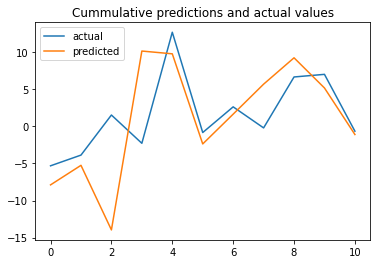

split_date: 2020-10-26 00:00:00
Epoch 1/144
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/144
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/144
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/144
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/144
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/144
2615/2615 - 6s - loss: 0.0181 - 6s/epoch - 2ms/step
Epoch 7/144
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 8/144
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 9/144
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/144
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 11/144
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 12/144
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/144
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 14/144
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 15/144
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Ep

Epoch 127/144
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 128/144
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 129/144
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 130/144
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 131/144
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 132/144
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 133/144
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 134/144
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 135/144
2615/2615 - 6s - loss: 0.0142 - 6s/epoch - 2ms/step
Epoch 136/144
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 137/144
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 138/144
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 139/144
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 140/144
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 141/144
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 142/

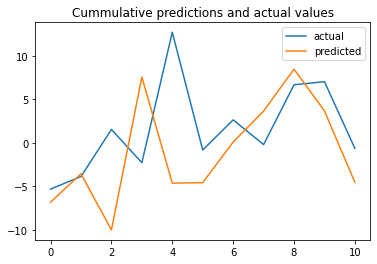

split_date: 2020-10-26 00:00:00
Epoch 1/146
2615/2615 - 7s - loss: 0.0192 - 7s/epoch - 3ms/step
Epoch 2/146
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/146
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/146
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/146
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/146
2615/2615 - 5s - loss: 0.0181 - 5s/epoch - 2ms/step
Epoch 7/146
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/146
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/146
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/146
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/146
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/146
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/146
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/146
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/146
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

Epoch 127/146
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 128/146
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 129/146
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 130/146
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 131/146
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 132/146
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 133/146
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 134/146
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 135/146
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 136/146
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 137/146
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 138/146
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 139/146
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 140/146
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 141/146
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 142/

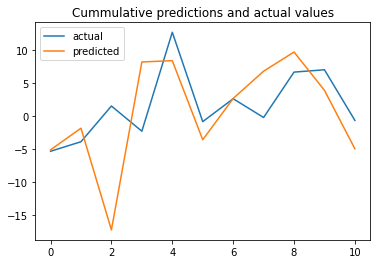

split_date: 2020-10-26 00:00:00
Epoch 1/148
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 2/148
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/148
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/148
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/148
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/148
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/148
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/148
2615/2615 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 9/148
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/148
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 11/148
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 12/148
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 13/148
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step
Epoch 14/148
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/148
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

Epoch 127/148
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 128/148
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 129/148
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 130/148
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 131/148
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 132/148
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 133/148
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 134/148
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 135/148
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 136/148
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 137/148
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 138/148
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 139/148
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 140/148
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 141/148
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 142/

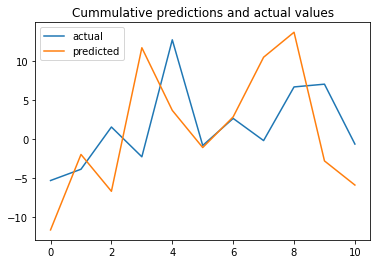

split_date: 2020-10-26 00:00:00
Epoch 1/150
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/150
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/150
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/150
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/150
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/150
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/150
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/150
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 9/150
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/150
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 11/150
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 12/150
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 13/150
2615/2615 - 6s - loss: 0.0160 - 6s/epoch - 2ms/step
Epoch 14/150
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Epoch 15/150
2615/2615 - 6s - loss: 0.0157 - 6s/epoch - 2ms/step
Ep

Epoch 127/150
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 128/150
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 129/150
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 130/150
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 131/150
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 132/150
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 133/150
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 134/150
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 135/150
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 136/150
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 137/150
2615/2615 - 7s - loss: 0.0140 - 7s/epoch - 3ms/step
Epoch 138/150
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 139/150
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 140/150
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 141/150
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 142/

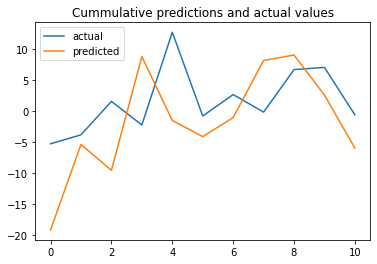

split_date: 2020-10-26 00:00:00
Epoch 1/152
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/152
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/152
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/152
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/152
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/152
2615/2615 - 8s - loss: 0.0180 - 8s/epoch - 3ms/step
Epoch 7/152
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/152
2615/2615 - 5s - loss: 0.0173 - 5s/epoch - 2ms/step
Epoch 9/152
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/152
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 11/152
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 12/152
2615/2615 - 5s - loss: 0.0163 - 5s/epoch - 2ms/step
Epoch 13/152
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/152
2615/2615 - 5s - loss: 0.0159 - 5s/epoch - 2ms/step
Epoch 15/152
2615/2615 - 5s - loss: 0.0157 - 5s/epoch - 2ms/step
Ep

Epoch 127/152
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 128/152
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 129/152
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 130/152
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 131/152
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 132/152
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 133/152
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 134/152
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 135/152
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 136/152
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 137/152
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 138/152
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 139/152
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 140/152
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 141/152
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 142/

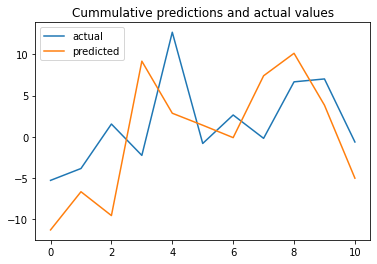

split_date: 2020-10-26 00:00:00
Epoch 1/154
2615/2615 - 9s - loss: 0.0192 - 9s/epoch - 3ms/step
Epoch 2/154
2615/2615 - 8s - loss: 0.0191 - 8s/epoch - 3ms/step
Epoch 3/154
2615/2615 - 7s - loss: 0.0190 - 7s/epoch - 3ms/step
Epoch 4/154
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/154
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/154
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/154
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/154
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/154
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/154
2615/2615 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step
Epoch 11/154
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 12/154
2615/2615 - 7s - loss: 0.0164 - 7s/epoch - 3ms/step
Epoch 13/154
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/154
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/154
2615/2615 - 6s - loss: 0.0158 - 6s/epoch - 2ms/step
Ep

Epoch 127/154
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 128/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 129/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 130/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 131/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 132/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 133/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 134/154
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 135/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 136/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 137/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 138/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 139/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 140/154
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 141/154
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 142/

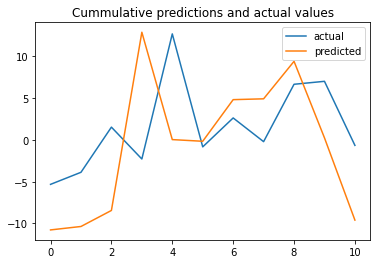

split_date: 2020-10-26 00:00:00
Epoch 1/156
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 2/156
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/156
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/156
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/156
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/156
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/156
2615/2615 - 5s - loss: 0.0176 - 5s/epoch - 2ms/step
Epoch 8/156
2615/2615 - 5s - loss: 0.0173 - 5s/epoch - 2ms/step
Epoch 9/156
2615/2615 - 5s - loss: 0.0170 - 5s/epoch - 2ms/step
Epoch 10/156
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/156
2615/2615 - 5s - loss: 0.0164 - 5s/epoch - 2ms/step
Epoch 12/156
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step
Epoch 13/156
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step
Epoch 14/156
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Epoch 15/156
2615/2615 - 5s - loss: 0.0157 - 5s/epoch - 2ms/step
Ep

Epoch 127/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 128/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 129/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 130/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 131/156
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 132/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 133/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 134/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 135/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 136/156
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 137/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 138/156
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 139/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 140/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 141/156
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 142/

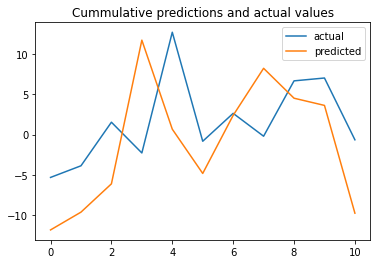

split_date: 2020-10-26 00:00:00
Epoch 1/158
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/158
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/158
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/158
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/158
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/158
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/158
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/158
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/158
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 10/158
2615/2615 - 5s - loss: 0.0168 - 5s/epoch - 2ms/step
Epoch 11/158
2615/2615 - 5s - loss: 0.0166 - 5s/epoch - 2ms/step
Epoch 12/158
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 13/158
2615/2615 - 5s - loss: 0.0161 - 5s/epoch - 2ms/step
Epoch 14/158
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/158
2615/2615 - 5s - loss: 0.0158 - 5s/epoch - 2ms/step
Ep

Epoch 127/158
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 128/158
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 129/158
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 130/158
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 131/158
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 132/158
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 133/158
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 134/158
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 135/158
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 136/158
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 137/158
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 138/158
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 139/158
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 140/158
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 141/158
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 142/

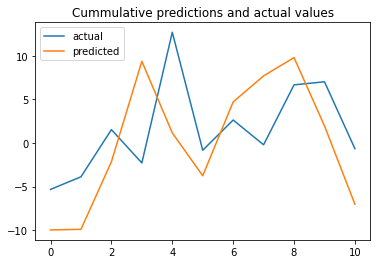

split_date: 2020-10-26 00:00:00
Epoch 1/160
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/160
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/160
2615/2615 - 5s - loss: 0.0189 - 5s/epoch - 2ms/step
Epoch 4/160
2615/2615 - 5s - loss: 0.0186 - 5s/epoch - 2ms/step
Epoch 5/160
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/160
2615/2615 - 5s - loss: 0.0180 - 5s/epoch - 2ms/step
Epoch 7/160
2615/2615 - 5s - loss: 0.0177 - 5s/epoch - 2ms/step
Epoch 8/160
2615/2615 - 5s - loss: 0.0174 - 5s/epoch - 2ms/step
Epoch 9/160
2615/2615 - 5s - loss: 0.0172 - 5s/epoch - 2ms/step
Epoch 10/160
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 11/160
2615/2615 - 5s - loss: 0.0167 - 5s/epoch - 2ms/step
Epoch 12/160
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step
Epoch 13/160
2615/2615 - 5s - loss: 0.0162 - 5s/epoch - 2ms/step
Epoch 14/160
2615/2615 - 5s - loss: 0.0160 - 5s/epoch - 2ms/step
Epoch 15/160
2615/2615 - 6s - loss: 0.0159 - 6s/epoch - 2ms/step
Ep

Epoch 127/160
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 128/160
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 129/160
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 130/160
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 131/160
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 132/160
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 133/160
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 134/160
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 135/160
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 136/160
2615/2615 - 6s - loss: 0.0140 - 6s/epoch - 2ms/step
Epoch 137/160
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 138/160
2615/2615 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 139/160
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 140/160
2615/2615 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 141/160
2615/2615 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step
Epoch 142/

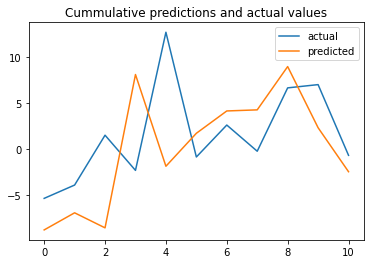

In [41]:
epochs_dic = {}
window = window_result.sort_values(by="MAE").index[0]

for epoch in epoch_lst:
    split_date = list(train.index[-(2 * window + 1):])[0]
    print("split_date:", split_date)

    # Split the training and test set
    training_set, test_set = train.loc[train.index < split_date], train.loc[train.index >= split_date]

    # Create windows for training
    LSTM_training_inputs, LSTM_training_outputs = make_train_window(training_set, window)

    # Create windows for testing
    LSTM_test_inputs, LSTM_test_outputs = make_test_window(test_set, window)

    # initialise model architecture
    nn_model = build_model(LSTM_training_inputs, output_size=737, neurons=32)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch

    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                              epochs=epoch, batch_size=1, verbose=2, shuffle=True)
    
    plt.plot(LSTM_test_outputs.sum(axis=1), label="actual")
    plt.plot(nn_model.predict(LSTM_test_inputs).sum(axis=1), label="predicted")
    plt.legend()
    plt.title("Cummulative predictions and actual values")
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    epochs_dic[epoch] = MAE
epochs_result = pd.DataFrame(epochs_dic.values(), epochs_dic.keys()).rename(columns={0: "MAE"})

In [42]:
epochs_result.sort_values(by="MAE")

MAE
10   0.015686
12   0.015925
136  0.016130
18   0.016133
16   0.016386
..        ...
110  0.018459
134  0.018470
104  0.018656
106  0.018690
130  0.019073

[76 rows x 1 columns]

## Grid Search: Neurons

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 2/10
2615/2615 - 5s - loss: 0.0191 - 5s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 8s - loss: 0.0187 - 8s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0176 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0173 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step


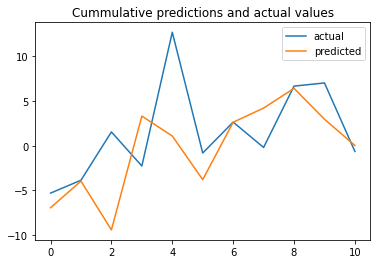

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0192 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0189 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0176 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0170 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step


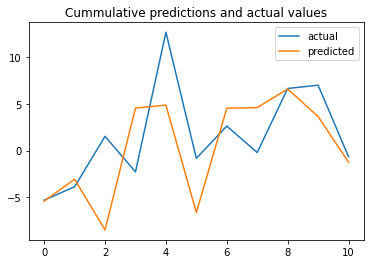

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0185 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0181 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0177 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0175 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0173 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step


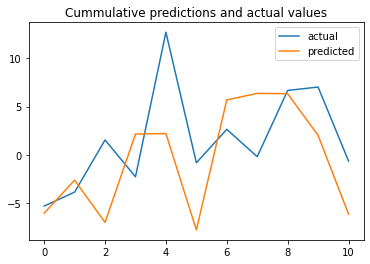

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0192 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0190 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step


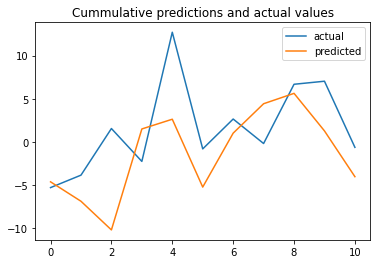

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0172 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step


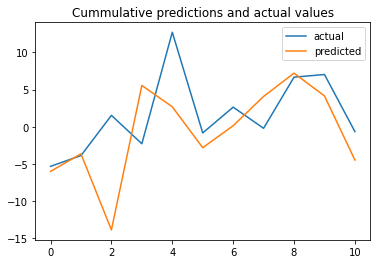

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0189 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 8s - loss: 0.0186 - 8s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0176 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0173 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0167 - 7s/epoch - 3ms/step


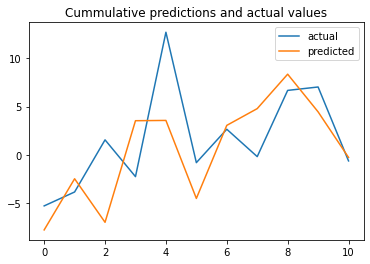

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0177 - 7s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step


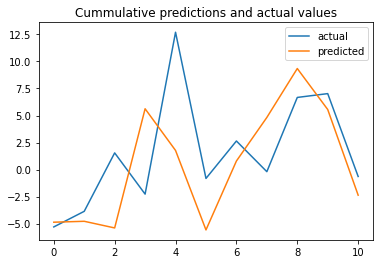

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0185 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0181 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0177 - 7s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0171 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step


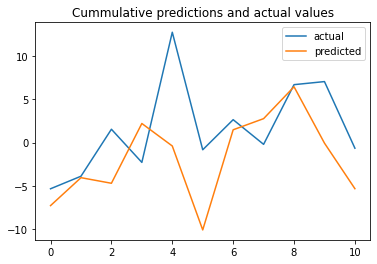

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0190 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 8s - loss: 0.0184 - 8s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0180 - 7s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0176 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0169 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0167 - 7s/epoch - 2ms/step


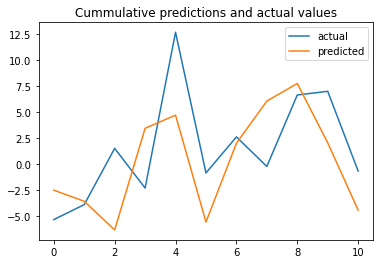

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0192 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0190 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0173 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step


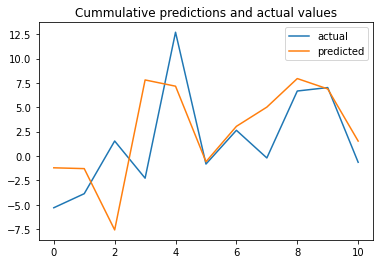

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step


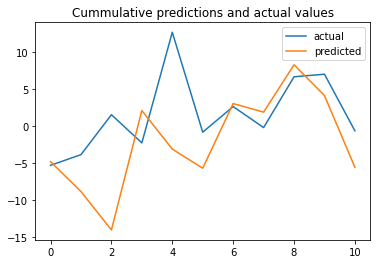

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0192 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0182 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0175 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step


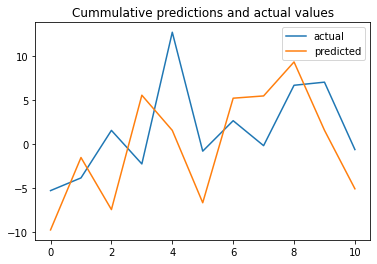

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step


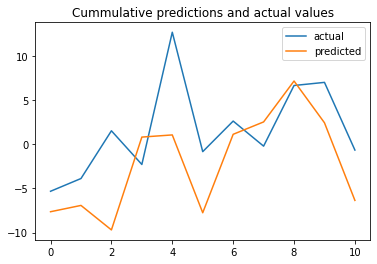

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0194 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 8s - loss: 0.0192 - 8s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0170 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step


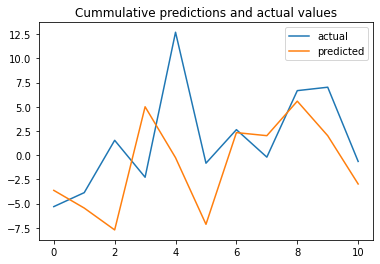

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 5s - loss: 0.0182 - 5s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step


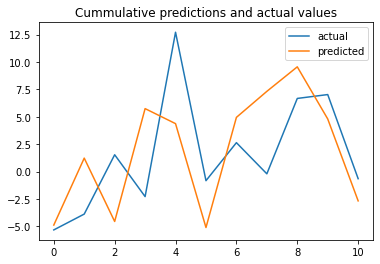

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0195 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0190 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step


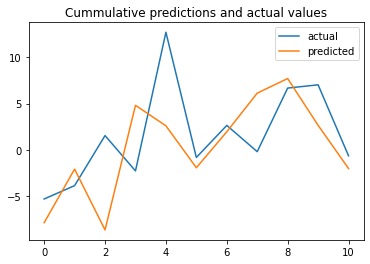

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0195 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0169 - 7s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step


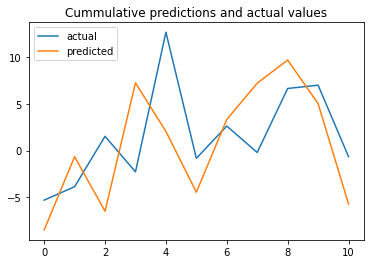

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0195 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0171 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0167 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0165 - 7s/epoch - 3ms/step


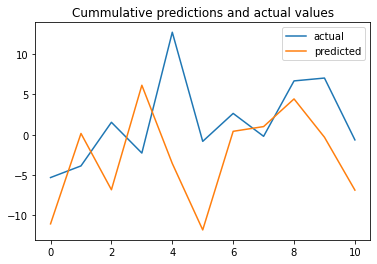

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0195 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0192 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step


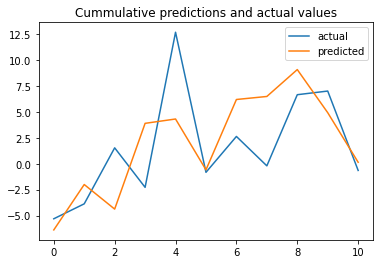

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0195 - 7s/epoch - 2ms/step
Epoch 2/10
2615/2615 - 5s - loss: 0.0192 - 5s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 5s - loss: 0.0190 - 5s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 5s - loss: 0.0175 - 5s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 5s - loss: 0.0171 - 5s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 5s - loss: 0.0169 - 5s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 5s - loss: 0.0165 - 5s/epoch - 2ms/step


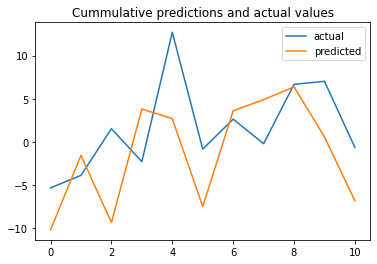

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 6s - loss: 0.0195 - 6s/epoch - 2ms/step
Epoch 2/10
2615/2615 - 5s - loss: 0.0192 - 5s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step


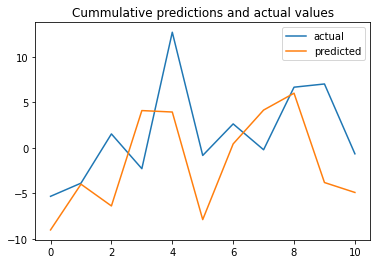

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0196 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0192 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0182 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0176 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step


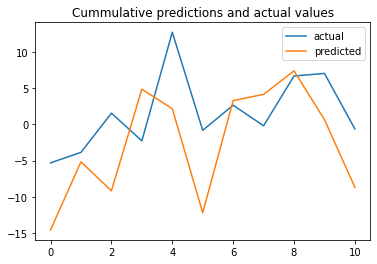

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 6s - loss: 0.0196 - 6s/epoch - 2ms/step
Epoch 2/10
2615/2615 - 5s - loss: 0.0192 - 5s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 5s - loss: 0.0184 - 5s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step


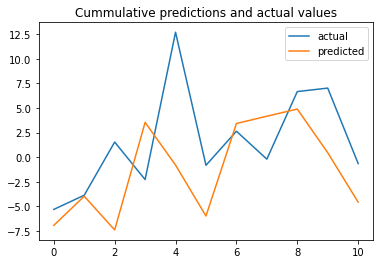

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0196 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 8s - loss: 0.0167 - 8s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0165 - 7s/epoch - 3ms/step


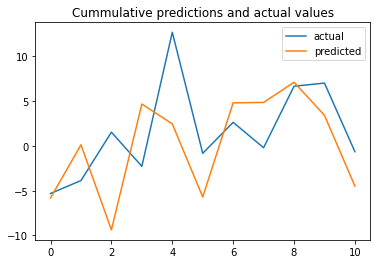

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0196 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0192 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0190 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0182 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0176 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step


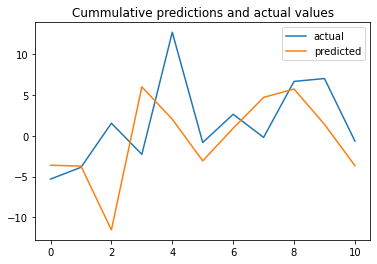

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0196 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step


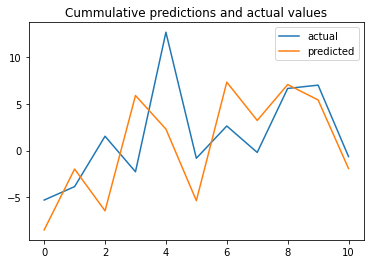

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 6s - loss: 0.0196 - 6s/epoch - 2ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0168 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step


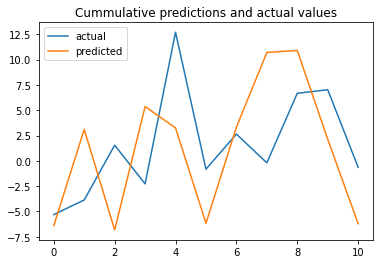

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0196 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0163 - 7s/epoch - 3ms/step


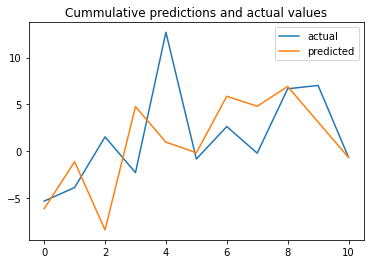

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0196 - 7s/epoch - 2ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0177 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step


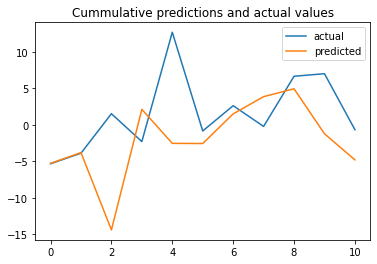

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0196 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0190 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0182 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0164 - 7s/epoch - 3ms/step


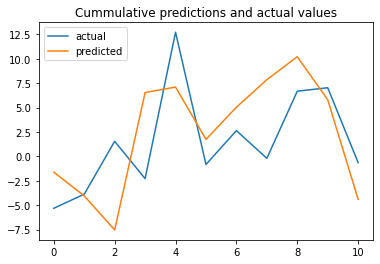

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0197 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step


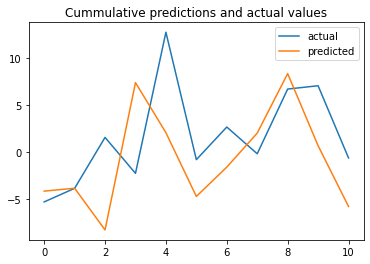

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 9s - loss: 0.0197 - 9s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0190 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0182 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step


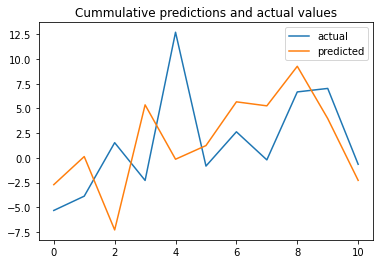

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0197 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0170 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step


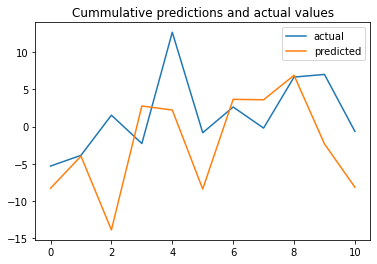

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0197 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0182 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0178 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0171 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0163 - 7s/epoch - 3ms/step


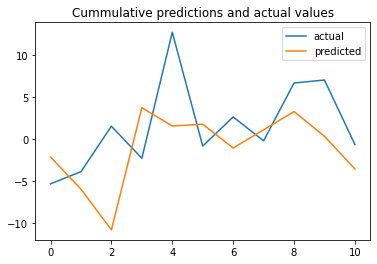

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0197 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0167 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step


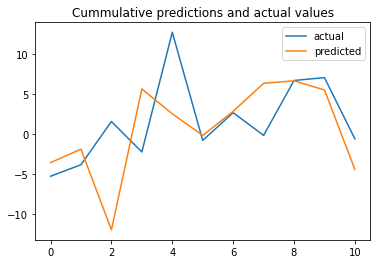

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0197 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 8s - loss: 0.0190 - 8s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0182 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0178 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0169 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step


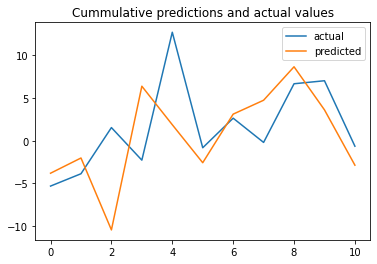

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0197 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0178 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0173 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0169 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0164 - 7s/epoch - 2ms/step


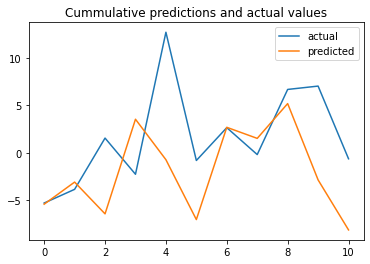

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0197 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0178 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 8s - loss: 0.0174 - 8s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 8s - loss: 0.0169 - 8s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step


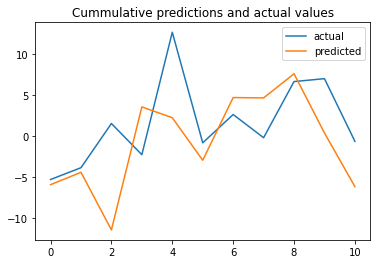

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0197 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 5s - loss: 0.0194 - 5s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 5s - loss: 0.0192 - 5s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0164 - 7s/epoch - 3ms/step


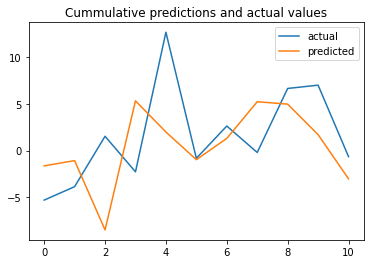

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0197 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0194 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step


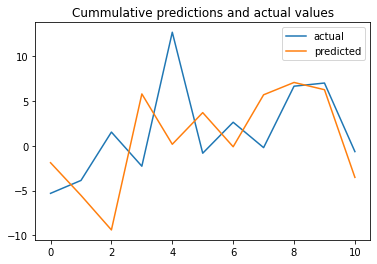

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0197 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0194 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0180 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0175 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0171 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0167 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0163 - 7s/epoch - 3ms/step


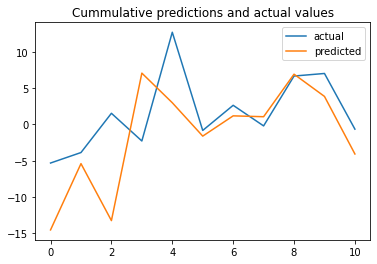

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0198 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0169 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step


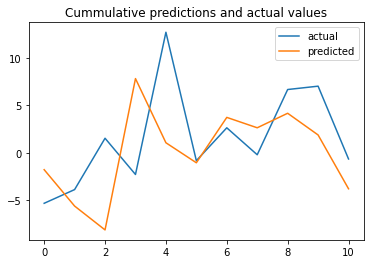

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0198 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0181 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0178 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0164 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step


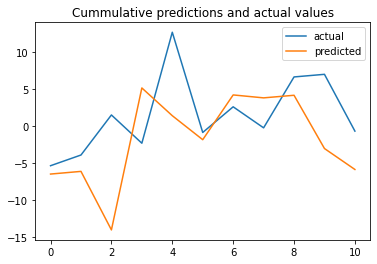

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0198 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step


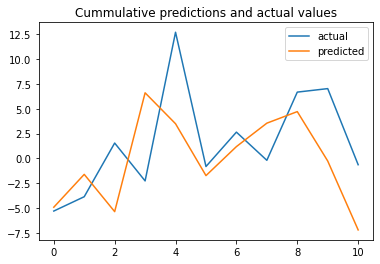

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0198 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0171 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0167 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0163 - 7s/epoch - 3ms/step


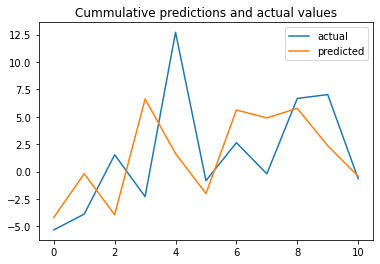

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0198 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0170 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0167 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0164 - 7s/epoch - 3ms/step


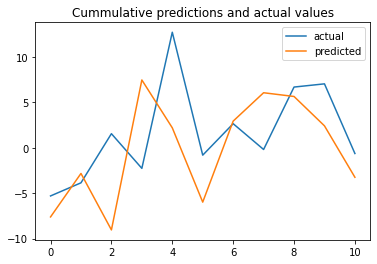

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0198 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0163 - 7s/epoch - 3ms/step


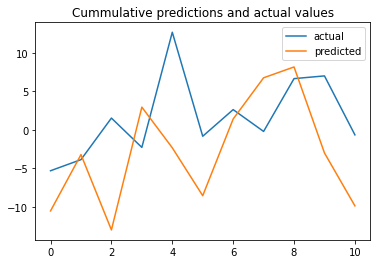

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0199 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 8s - loss: 0.0187 - 8s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 8s - loss: 0.0183 - 8s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 8s - loss: 0.0175 - 8s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0171 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0167 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0164 - 7s/epoch - 3ms/step


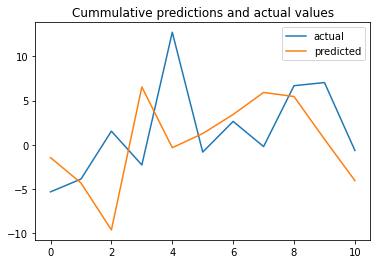

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0198 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 8s - loss: 0.0194 - 8s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0188 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 8s - loss: 0.0174 - 8s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0171 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step


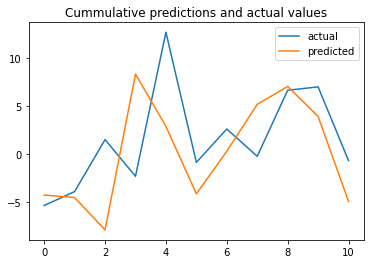

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 9s - loss: 0.0199 - 9s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step


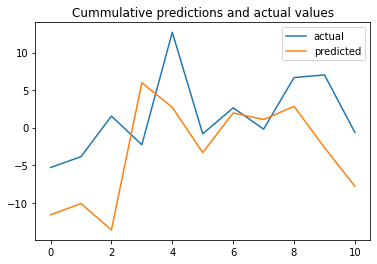

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0199 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step


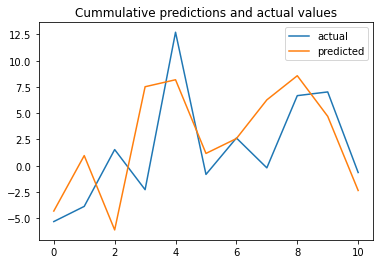

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0199 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0194 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0178 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0170 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step


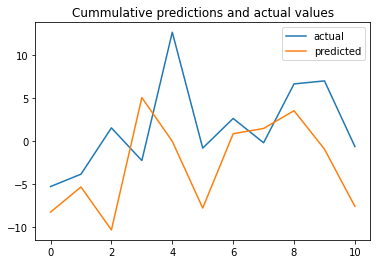

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 9s - loss: 0.0199 - 9s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0194 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0161 - 6s/epoch - 2ms/step


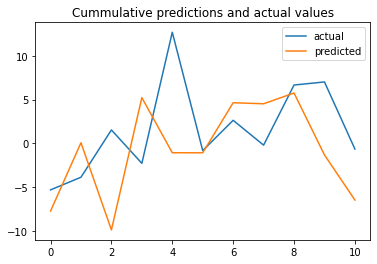

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0199 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0195 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0168 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0163 - 6s/epoch - 2ms/step


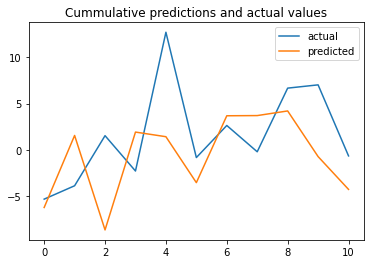

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 6s - loss: 0.0199 - 6s/epoch - 2ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0194 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0169 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0165 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step


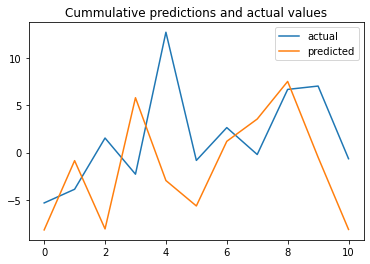

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0199 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 7s - loss: 0.0191 - 7s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0171 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step


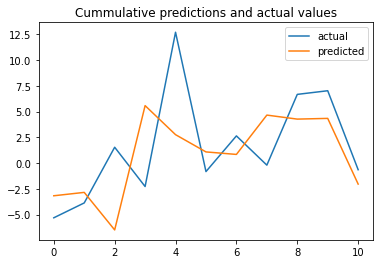

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0199 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0188 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step


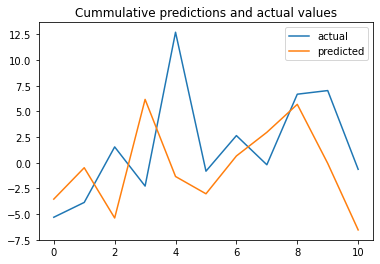

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0200 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0194 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0173 - 7s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0169 - 7s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0162 - 7s/epoch - 3ms/step


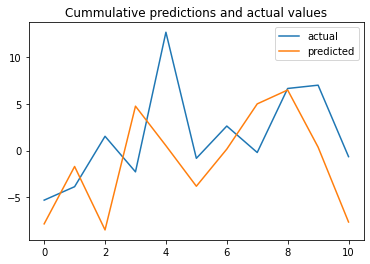

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0199 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0194 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0184 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0175 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0170 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0167 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0163 - 7s/epoch - 2ms/step


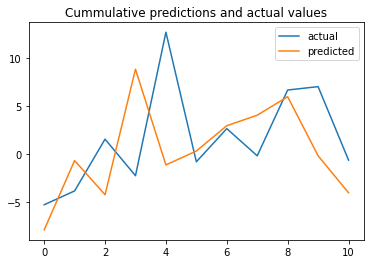

In [43]:
neuron_dic = {}
window = window_result.sort_values(by="MAE").index[0]
epoch = epochs_result.sort_values(by="MAE").index[0]

for neuron in neuron_lst:
    split_date = list(train.index[-(2 * window + 1):])[0]
    print("split_date:", split_date)

    # Split the training and test set
    training_set, test_set = train.loc[train.index < split_date], train.loc[train.index >= split_date]

    # Create windows for training
    LSTM_training_inputs, LSTM_training_outputs = make_train_window(training_set, window)

    # Create windows for testing
    LSTM_test_inputs, LSTM_test_outputs = make_test_window(test_set, window)

    # initialise model architecture
    nn_model = build_model(LSTM_training_inputs, output_size=737, neurons=neuron)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch

    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                              epochs=epoch, batch_size=1, verbose=2, shuffle=True)
    
    plt.plot(LSTM_test_outputs.sum(axis=1), label="actual")
    plt.plot(nn_model.predict(LSTM_test_inputs).sum(axis=1), label="predicted")
    plt.legend()
    plt.title("Cummulative predictions and actual values")
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    neuron_dic[neuron] = MAE
neuron_result = pd.DataFrame(neuron_dic.values(), neuron_dic.keys()).rename(columns={0: "MAE"})

In [44]:
neuron_result.sort_values(by="MAE")

MAE
56   0.015762
28   0.015840
24   0.015894
44   0.015906
36   0.015907
244  0.015926
96   0.015940
32   0.015999
52   0.016008
48   0.016059
80   0.016068
84   0.016122
72   0.016138
196  0.016159
224  0.016185
60   0.016192
76   0.016202
200  0.016204
112  0.016205
104  0.016207
124  0.016216
176  0.016236
132  0.016289
236  0.016293
156  0.016299
144  0.016331
100  0.016344
116  0.016357
216  0.016371
248  0.016372
188  0.016388
120  0.016390
68   0.016414
140  0.016423
168  0.016462
88   0.016463
252  0.016492
204  0.016505
40   0.016508
164  0.016563
160  0.016582
148  0.016587
256  0.016610
172  0.016664
180  0.016684
232  0.016691
212  0.016722
64   0.016806
184  0.016870
228  0.016900
136  0.016902
240  0.016971
128  0.017000
220  0.017015
92   0.017044
192  0.017050
152  0.017127
108  0.017162
208  0.017740

## Grid Search: Dropout rate

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 7s - loss: 0.0185 - 7s/epoch - 3ms/step
Epoch 5/10
2615/2615 - 7s - loss: 0.0181 - 7s/epoch - 3ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0173 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0169 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0166 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0162 - 6s/epoch - 2ms/step


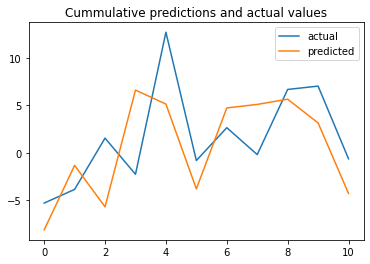

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0193 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 8s - loss: 0.0189 - 8s/epoch - 3ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 8s - loss: 0.0164 - 8s/epoch - 3ms/step


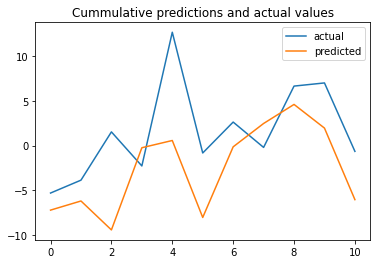

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0173 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 7s - loss: 0.0170 - 7s/epoch - 3ms/step
Epoch 10/10
2615/2615 - 8s - loss: 0.0167 - 8s/epoch - 3ms/step


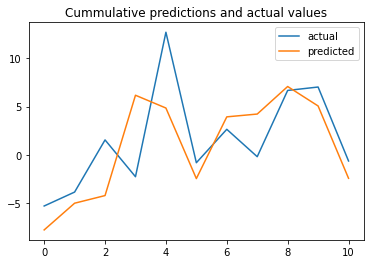

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 8s - loss: 0.0194 - 8s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0178 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0167 - 6s/epoch - 2ms/step


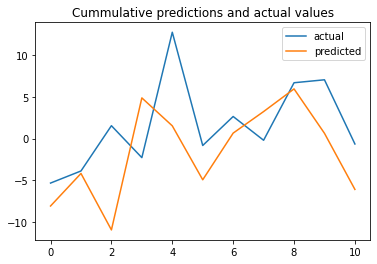

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0181 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0175 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0170 - 6s/epoch - 2ms/step


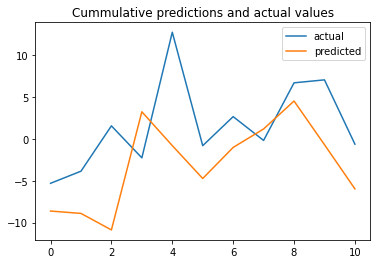

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0188 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0185 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step


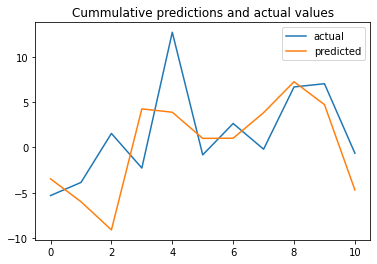

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0188 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0172 - 6s/epoch - 2ms/step


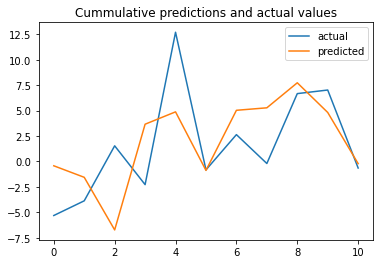

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0194 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0186 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0181 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0174 - 6s/epoch - 2ms/step


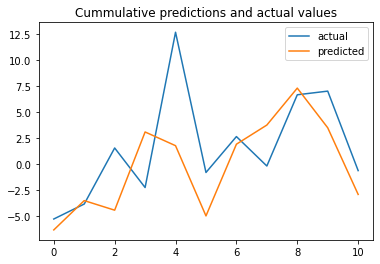

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0195 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0189 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 6s - loss: 0.0184 - 6s/epoch - 2ms/step
Epoch 7/10
2615/2615 - 6s - loss: 0.0183 - 6s/epoch - 2ms/step
Epoch 8/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0176 - 6s/epoch - 2ms/step


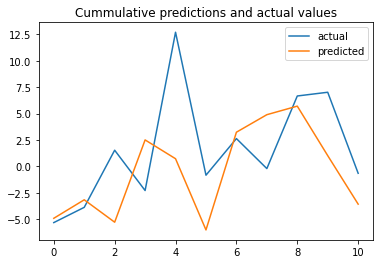

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0195 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0192 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0188 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0184 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0181 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0180 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 7s - loss: 0.0177 - 7s/epoch - 3ms/step


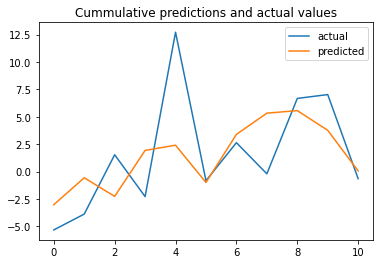

In [45]:
dropout_dic = {}
window = window_result.sort_values(by="MAE").index[0]
epoch = epochs_result.sort_values(by="MAE").index[0]
neuron = neuron_result.sort_values(by="MAE").index[0]

for dropout in dropout_lst:
    split_date = list(train.index[-(2 * window + 1):])[0]
    print("split_date:", split_date)

    # Split the training and test set
    training_set, test_set = train.loc[train.index < split_date], train.loc[train.index >= split_date]

    # Create windows for training
    LSTM_training_inputs, LSTM_training_outputs = make_train_window(training_set, window)

    # Create windows for testing
    LSTM_test_inputs, LSTM_test_outputs = make_test_window(test_set, window)

    # initialise model architecture
    nn_model = build_model(LSTM_training_inputs, output_size=737, neurons=neuron, 
                           activ_func="tanh", dropout=dropout)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch

    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                              epochs=epoch, batch_size=1, verbose=2, shuffle=True)
    
    plt.plot(LSTM_test_outputs.sum(axis=1), label="actual")
    plt.plot(nn_model.predict(LSTM_test_inputs).sum(axis=1), label="predicted")
    plt.legend()
    plt.title("Cummulative predictions and actual values")
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    dropout_dic[dropout] = MAE
dropout_result = pd.DataFrame(dropout_dic.values(), dropout_dic.keys()).rename(columns={0: "MAE"})

In [46]:
dropout_result.sort_values(by="MAE")

MAE
0.45  0.015257
0.35  0.015528
0.10  0.015633
0.30  0.015645
0.40  0.015653
0.25  0.015739
0.00  0.015795
0.05  0.015983
0.15  0.016239
0.20  0.016392

## 用Grid Search的结果训练模型

In [47]:
# Parameters
window = window_result.sort_values(by="MAE").index[0]
neuron = neuron_result.sort_values(by="MAE").index[0]
dropout = dropout_result.sort_values(by="MAE").index[0]
epoch = epochs_result.sort_values(by="MAE").index[0]

pd.Series({"window": window, "epoch": epoch, "neuron": neuron, "dropout": dropout})

window     10.00
epoch      10.00
neuron     56.00
dropout     0.45
dtype: float64

split_date: 2020-10-26 00:00:00
Epoch 1/10
2615/2615 - 7s - loss: 0.0195 - 7s/epoch - 3ms/step
Epoch 2/10
2615/2615 - 6s - loss: 0.0193 - 6s/epoch - 2ms/step
Epoch 3/10
2615/2615 - 6s - loss: 0.0191 - 6s/epoch - 2ms/step
Epoch 4/10
2615/2615 - 6s - loss: 0.0190 - 6s/epoch - 2ms/step
Epoch 5/10
2615/2615 - 6s - loss: 0.0187 - 6s/epoch - 2ms/step
Epoch 6/10
2615/2615 - 7s - loss: 0.0185 - 7s/epoch - 3ms/step
Epoch 7/10
2615/2615 - 7s - loss: 0.0183 - 7s/epoch - 3ms/step
Epoch 8/10
2615/2615 - 7s - loss: 0.0181 - 7s/epoch - 3ms/step
Epoch 9/10
2615/2615 - 6s - loss: 0.0179 - 6s/epoch - 2ms/step
Epoch 10/10
2615/2615 - 6s - loss: 0.0177 - 6s/epoch - 2ms/step


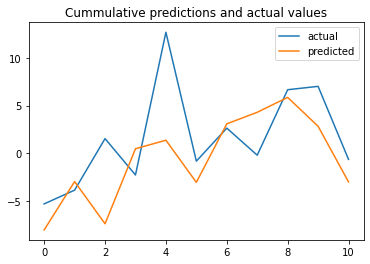

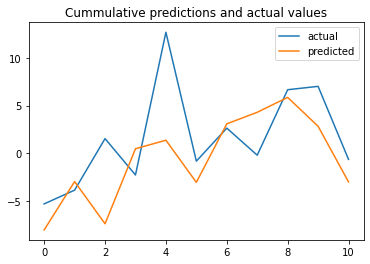

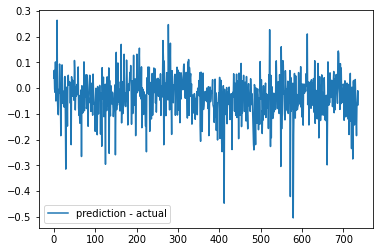

The loss is:  0.015493662


In [48]:
split_date = list(train.index[-(2 * window + 1):])[0]
print("split_date:", split_date)

# Split the training and test set
training_set, test_set = train.loc[train.index < split_date], train.loc[train.index >= split_date]

# Create windows for training
LSTM_training_inputs, LSTM_training_outputs = make_train_window(training_set, window)

# Create windows for testing
LSTM_test_inputs, LSTM_test_outputs = make_test_window(test_set, window)

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=737, neurons=neuron, 
                       activ_func="tanh", dropout=dropout, optimizer="adam")
# model output is next price normalised to 10th previous closing price train model on data
# note: eth_history contains information on the training error per epoch

nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                          epochs=epoch, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs.sum(axis=1), label="actual")
plt.plot(nn_model.predict(LSTM_test_inputs).sum(axis=1), label="predicted")
plt.legend()
plt.title("Cummulative predictions and actual values")
plt.show()

plt.plot(LSTM_test_outputs.sum(axis=1), label="actual")
plt.plot(nn_model.predict(LSTM_test_inputs).sum(axis=1), label="predicted")
plt.legend()
plt.title("Cummulative predictions and actual values")
plt.show()

plt.plot(nn_model.predict(LSTM_test_inputs).sum(axis=0)-LSTM_test_outputs.sum(axis=0), label="prediction - actual")
plt.legend()
plt.show()

print("The loss is: ", mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs)))

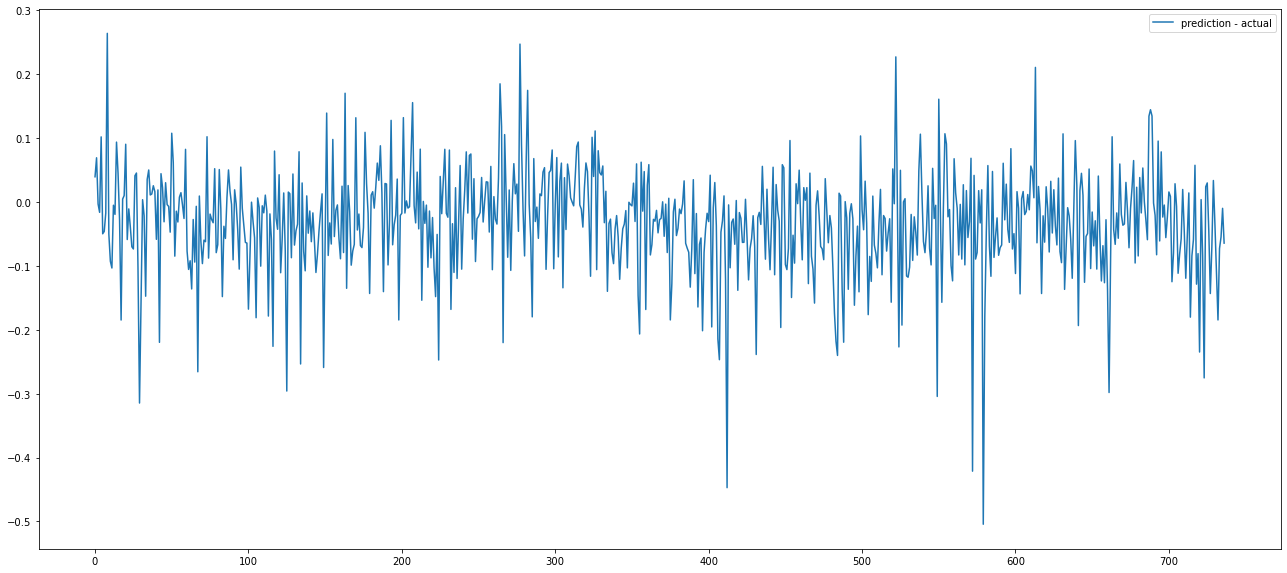

In [49]:
fig, axs = plt.subplots(1, 1)
plt.subplots_adjust(top = 2, right=3, hspace = 0.3)

axs.plot(nn_model.predict(LSTM_test_inputs).sum(axis=0)-LSTM_test_outputs.sum(axis=0), label="prediction - actual")
axs.legend()

plt.show()

In [50]:
result_plot(x=stock_codes, y=nn_model.predict(LSTM_test_inputs).sum(axis=0)-LSTM_test_outputs.sum(axis=0), 
            title="final accumulated result of each stock: prediction - actual")

In [51]:
prediction = pd.DataFrame(nn_model.predict(np.array([test[i:(i+window)].values 
                                                     for i in range(len(test)-window)])))

prediction.columns = stock_codes
prediction.index = test.index[window: ]
prediction.head(3)

000006    000009    000012    000016    000021    000025  \
date                                                                     
2020-12-08  0.003383 -0.004080 -0.001368 -0.002920 -0.003134 -0.007152   
2020-12-09 -0.000706 -0.012770 -0.008331 -0.009163 -0.013207 -0.013345   
2020-12-10 -0.010075 -0.020852 -0.018750 -0.018208 -0.023245 -0.020980   

              000027    000028    000029    000031  ...    601168    601333  \
date                                                ...                       
2020-12-08 -0.002125 -0.001585 -0.001331 -0.002088  ...  0.000963 -0.003797   
2020-12-09 -0.003510 -0.003727 -0.002117 -0.005336  ... -0.002295 -0.004708   
2020-12-10 -0.012839 -0.009818 -0.007316 -0.015016  ... -0.013199 -0.013607   

              601588    601666    601699    601866    601872    601958  \
date                                                                     
2020-12-08  0.003888  0.003863  0.000071 -0.006716 -0.006052  0.001634   
2020-12-09 -0.000114  0.000848 -0.004622 -0.008167 -0.009673 -0.002499   
2020-12-10 -0.009218 -0.011827 -0.016445 -0.016687 -0.017265 -0.013158   

              601991    601999  
date                            
2020-12-08 -0.001174 -0.001603  
2020-12-09 -0.003456 -0.009436  
2020-12-10 -0.011170 -0.017862  

[3 rows x 737 columns]

**现在，prediction为测试集的预测结果，而test为真实结果。直接一点，每日换仓，等权重long预测结果前 N 支股票，根据实际数据累计收益率。当然，如果不巧预测到泥沙俱下的情况（即便是前 N 支股票也不全为正收益率），则空仓一天。**

In [52]:
print(f"交易天数: {len(prediction)}")

for N in range(5, 51):
    accumulated_returns = 0
    for date in prediction.index:
        predict_today = prediction.loc[date].sort_values(ascending=False)[:N]
        if np.nansum(predict_today <= 0) > 0:
            continue
        else:
            actual_today = np.nanmean(test.loc[date][predict_today.index]) 
            accumulated_returns += actual_today

    print(f"持股支数: {N}, 累计收益率: {100*accumulated_returns} %")

交易天数: 284
持股支数: 5, 累计收益率: 32.66567670398217 %
持股支数: 6, 累计收益率: 32.770034239547385 %
持股支数: 7, 累计收益率: 29.404062614776194 %
持股支数: 8, 累计收益率: 25.280695006949827 %
持股支数: 9, 累计收益率: 20.726191372887115 %
持股支数: 10, 累计收益率: 19.916659847149276 %
持股支数: 11, 累计收益率: 12.285763706313446 %
持股支数: 12, 累计收益率: 10.949826867727097 %
持股支数: 13, 累计收益率: 10.910257968498627 %
持股支数: 14, 累计收益率: 7.289924947326654 %
持股支数: 15, 累计收益率: 5.555803338938858 %
持股支数: 16, 累计收益率: 5.4218316450715065 %
持股支数: 17, 累计收益率: 9.759617623785743 %
持股支数: 18, 累计收益率: 10.898193133834866 %
持股支数: 19, 累计收益率: 8.581738495558966 %
持股支数: 20, 累计收益率: 7.1659453362372005 %
持股支数: 21, 累计收益率: 3.941120594390668 %
持股支数: 22, 累计收益率: 1.5875726888225472 %
持股支数: 23, 累计收益率: 4.561789359377144 %
持股支数: 24, 累计收益率: 1.5758962472318672 %
持股支数: 25, 累计收益率: 3.1708030921208774 %
持股支数: 26, 累计收益率: 1.1856901561259292 %
持股支数: 27, 累计收益率: 2.8144422965851845 %
持股支数: 28, 累计收益率: 2.7430031785115716 %
持股支数: 29, 累计收益率: 6.138681265292689 %
持股支数: 30, 累计收益率: 9.763451281469315 %
持股支数: 31, 累计收益率: